#### Pharmacy Sales & Profitability Analytics Challenge
---

##### 🎯 Objective

This project analyzes daily sales transactions from a European pharmacy distributor to understand:

- Revenue and profitability trends over time  
- Geographic performance across countries and regions  
- Pharmacy-level benchmarking within regions  
- Product category and brand contribution to margin  
- The impact of promotions on volume and profitability  

The final deliverable is an interactive Power BI report that enables stakeholders to drill down from executive KPIs to pharmacy- and product-level insights.

---

##### 👥 Primary Stakeholders

The primary audience for this report includes:

- Executive leadership monitoring overall profitability  
- Regional managers comparing performance across regions  
- Category managers evaluating product and promotion strategy  

---

##### 📂 Dataset Overview

The dataset represents a pharmacy distributor operating across Europe.

**Tables included:**

- **FactSales** — daily transactions
- **DimDate** — calendar attributes
- **DimPharmacy** — location + store type
- **DimProduct** — category + brand hierarchy

---

##### 🧱 Data Model (Star Schema)

The dataset follows a star schema:

- **FactSales** is the central transaction table  
- **DimDate** connects via DateKey  
- **DimPharmacy** connects via PharmacyID  
- **DimProduct** connects via ProductID  

This structure supports drilldowns and high-performance Power BI modeling.

---

##### 🧹 Data Wrangling Steps

We perform the following preparation before dashboarding:

1. Validate primary keys and relationships  
2. Check for missing or inconsistent values  
3. Confirm margin calculations  
4. Convert DateKey into datetime format  
5. Prepare promotion flags for analysis  

---

##### 📊 Key Metrics

**Core business measures:**

- Total Revenue (EUR)
- Units Sold
- Total Profit (Revenue - Cost)
- Margin %
- Promo vs Non-Promo performance
- Regional contribution to total profit

---

In [1]:
import pandas as pd
file_path = "C:/Users/adith/pharmacy_sales_and_profitability_challenge/January-February_2026_ZoomCHarts_Onyx_Pharma_Sales_Dataset/Pharmacy_Data_Challenge_Dataset.xlsx"
xls = pd.ExcelFile(file_path)
print(xls.sheet_names)

['FactSales', 'DimDate', 'DimPharmacy', 'DimProduct', 'Data Dictionary', 'README']


In [2]:
all_sheets = pd.read_excel(file_path, sheet_name=None)
print(all_sheets.keys())

dict_keys(['FactSales', 'DimDate', 'DimPharmacy', 'DimProduct', 'Data Dictionary', 'README'])


In [3]:
sales_df = all_sheets['FactSales']
date_df = all_sheets['DimDate']
pharmacy_df = all_sheets['DimPharmacy']
product_df = all_sheets['DimProduct']

In [4]:
for name, df in all_sheets.items():
    print("\n---", name, "---")
    print("Shape:", df.shape)
    print(df.head(2))



--- FactSales ---
Shape: (62139, 9)
    SalesID   DateKey PharmacyID ProductID  UnitsSold  RevenueEUR  CostEUR  \
0  S0000001  20240101     PH0002    PR0099          5      128.08    87.55   
1  S0000002  20240101     PH0004    PR0156          4       51.89    34.32   

   MarginEUR PromoFlag  
0      40.53        No  
1      17.57        No  

--- DimDate ---
Shape: (731, 7)
    DateKey       Date  Year  Quarter  MonthNumber MonthName YearMonth
0  20240101 2024-01-01  2024        1            1   January   2024-01
1  20240102 2024-01-02  2024        1            1   January   2024-01

--- DimPharmacy ---
Shape: (120, 10)
  PharmacyID                PharmacyName  Country    Region       City  \
0     PH0001     Naples HealthPoint #001    Italy  Campania     Naples   
1     PH0002  Innsbruck HealthPoint #002  Austria     Tyrol  Innsbruck   

  PharmacyType    OpenDate StoreSizeBand   Latitude  Longitude  
0     Suburban  2025-04-03             M  40.839137  14.279288  
1        Urban  

In [5]:
for name, df in all_sheets.items():
    df.to_csv(f"{name}.csv", index=False)
    print(f"Saved: {name}.csv  Shape: {df.shape}")
    print("All tables saved successfully!")
    

Saved: FactSales.csv  Shape: (62139, 9)
All tables saved successfully!
Saved: DimDate.csv  Shape: (731, 7)
All tables saved successfully!
Saved: DimPharmacy.csv  Shape: (120, 10)
All tables saved successfully!
Saved: DimProduct.csv  Shape: (220, 11)
All tables saved successfully!
Saved: Data Dictionary.csv  Shape: (37, 11)
All tables saved successfully!
Saved: README.csv  Shape: (24, 1)
All tables saved successfully!


#### FactSales Table (Transaction Fact)

The FactSales table contains daily sales transactions across pharmacies and products.

Each row represents:

**One product sold in one pharmacy on one day**

This is the central fact table used for all revenue, cost, and profitability analysis.

##### Columns:

- SalesID: Unique transaction identifier  
- DateKey: Foreign key linking to DimDate  
- PharmacyID: Foreign key linking to DimPharmacy  
- ProductID: Foreign key linking to DimProduct  
- UnitsSold: Quantity sold  
- RevenueEUR: Sales revenue in EUR  
- CostEUR: Cost of goods sold  
- MarginEUR: Profit (Revenue - Cost)  
- PromoFlag: Indicates whether the sale was promoted  


In [27]:
sales_df.head()

,SalesID,DateKey,PharmacyID,ProductID,UnitsSold,RevenueEUR,CostEUR,MarginEUR,PromoFlag
0,S0000001,20240101,PH0002,PR0099,5,128.08,87.55,40.53,No
1,S0000002,20240101,PH0004,PR0156,4,51.89,34.32,17.57,No
2,S0000003,20240101,PH0007,PR0004,20,317.73,199.53,118.20,No
3,S0000004,20240101,PH0009,PR0075,6,90.34,67.49,22.85,No
4,S0000005,20240101,PH0010,PR0154,2,160.21,124.99,35.22,Yes


In [28]:
sales_df["SalesID"].nunique() # Sales id is unique


62139

In [29]:
sales_df.shape

(62139, 9)

In [30]:
sales_df["SalesID"].isnull().sum() # no null values 

np.int64(0)

In [31]:
sales_df["CalculatedMargin"] = sales_df["RevenueEUR"] - sales_df["CostEUR"]
(sales_df["CalculatedMargin"].round(2) == sales_df["MarginEUR"].round(2)).value_counts()


True    62139
Name: count, dtype: int64

In [32]:
# DateKey Conversion
sales_df["DateKey"] = sales_df["DateKey"].astype(str)
sales_df["Date"] = pd.to_datetime(sales_df["DateKey"], format="%Y%m%d")

#### Add profitability measures

**Margin%**

In [33]:
sales_df["MarginPct"] = sales_df["MarginEUR"] / sales_df["RevenueEUR"]


**Revenue per Unit**

In [34]:
sales_df["RevenuePerUnit"] = sales_df["RevenueEUR"] / sales_df["UnitsSold"]


**Profit per Unit**

In [35]:
sales_df["ProfitPerUnit"] = sales_df["MarginEUR"] / sales_df["UnitsSold"]


In [36]:
sales_df.head()

,SalesID,DateKey,PharmacyID,ProductID,UnitsSold,RevenueEUR,CostEUR,MarginEUR,PromoFlag,CalculatedMargin,Date,MarginPct,RevenuePerUnit,ProfitPerUnit
0,S0000001,20240101,PH0002,PR0099,5,128.08,87.55,40.53,No,40.53,2024-01-01,0.316443,25.616000,8.106000
1,S0000002,20240101,PH0004,PR0156,4,51.89,34.32,17.57,No,17.57,2024-01-01,0.338601,12.972500,4.392500
2,S0000003,20240101,PH0007,PR0004,20,317.73,199.53,118.20,No,118.20,2024-01-01,0.372014,15.886500,5.910000
3,S0000004,20240101,PH0009,PR0075,6,90.34,67.49,22.85,No,22.85,2024-01-01,0.252933,15.056667,3.808333
4,S0000005,20240101,PH0010,PR0154,2,160.21,124.99,35.22,Yes,35.22,2024-01-01,0.219836,80.105000,17.610000


In [38]:
(sales_df["UnitsSold"] <= 0).sum()

np.int64(0)

In [39]:
(sales_df["RevenueEUR"] < 0).sum()


np.int64(0)

In [40]:
(sales_df["CostEUR"] > sales_df["RevenueEUR"]).sum()


np.int64(0)

In [41]:
sales_df["PromoFlag"].value_counts(normalize=True)


PromoFlag
No     0.880413
Yes    0.119587
Name: proportion, dtype: float64

In [43]:
sales_df["Date"].min()



Timestamp('2024-01-01 00:00:00')

In [ ]:
sales_df["Date"].max() # span for 2 years

Timestamp('2025-12-31 00:00:00')

In [45]:
missing_pharmacies = set(sales_df["PharmacyID"]) - set(pharmacy_df["PharmacyID"])
missing_products   = set(sales_df["ProductID"]) - set(sales_df["ProductID"])
missing_dates      = set(sales_df["DateKey"]) - set(date_df["DateKey"].astype(str))

print("Missing Pharmacies:", missing_pharmacies)
print("Missing Products:", missing_products)
print("Missing Dates:", missing_dates)


Missing Pharmacies: set()
Missing Products: set()
Missing Dates: set()


**1. Revenue Over Time**

In [47]:
sales_df["Year"] = sales_df["Date"].dt.year
sales_df["Year"].value_counts()


Year
2025    31827
2024    30312
Name: count, dtype: int64

In [54]:
sales_df["Year"] = sales_df["Date"].dt.year
sales_df["Month"] = sales_df["Date"].dt.month


In [55]:
monthly_rev = (
    sales_df.groupby(["Year", "Month"])["RevenueEUR"]
    .sum()
    .reset_index()
)


In [56]:
print(monthly_rev.head())
print(monthly_rev.columns)


   Year  Month  RevenueEUR
0  2024      1   348141.16
1  2024      2   327319.25
2  2024      3   346366.74
3  2024      4   330369.31
4  2024      5   357866.97
Index(['Year', 'Month', 'RevenueEUR'], dtype='object')


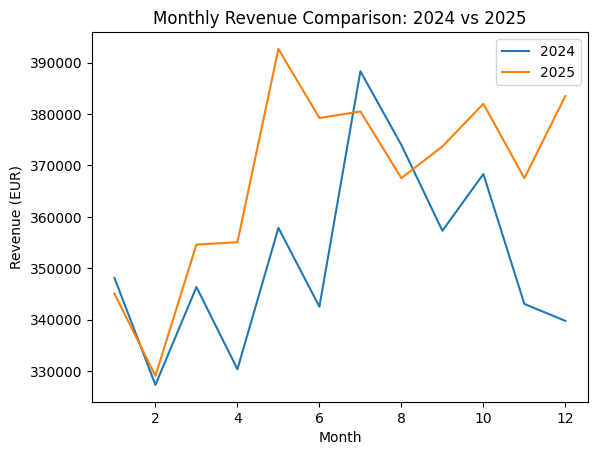

In [57]:
import matplotlib.pyplot as plt

rev_2024 = monthly_rev[monthly_rev["Year"] == 2024]
rev_2025 = monthly_rev[monthly_rev["Year"] == 2025]

plt.figure()
plt.plot(rev_2024["Month"], rev_2024["RevenueEUR"], label="2024")
plt.plot(rev_2025["Month"], rev_2025["RevenueEUR"], label="2025")

plt.title("Monthly Revenue Comparison: 2024 vs 2025")
plt.xlabel("Month")
plt.ylabel("Revenue (EUR)")
plt.legend()
plt.show()


**2. Monthly Margin % Comparison (Profitability Shift)**

In [60]:
monthly_margin = (
    sales_df.groupby(["Year", "Month"])
    .agg({"RevenueEUR":"sum", "MarginEUR":"sum"})
    .reset_index()
)

monthly_margin["MarginPct"] = monthly_margin["MarginEUR"] / monthly_margin["RevenueEUR"]
monthly_margin.columns = ["Year", "Month", "RevenueEUR", "MarginEUR", "MarginPct"]


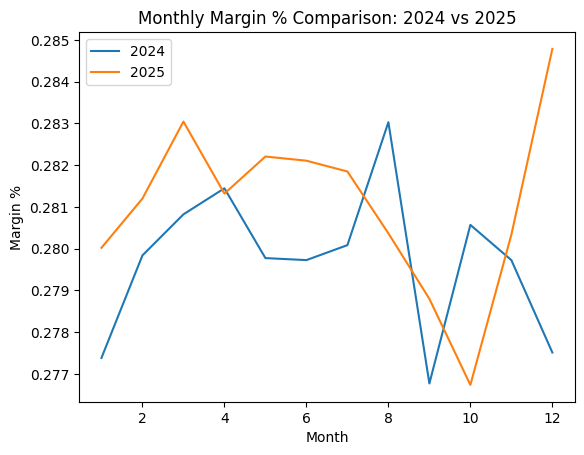

In [61]:
m_2024 = monthly_margin[monthly_margin["Year"] == 2024]
m_2025 = monthly_margin[monthly_margin["Year"] == 2025]

plt.figure()
plt.plot(m_2024["Month"], m_2024["MarginPct"], label="2024")
plt.plot(m_2025["Month"], m_2025["MarginPct"], label="2025")

plt.title("Monthly Margin % Comparison: 2024 vs 2025")
plt.xlabel("Month")
plt.ylabel("Margin %")
plt.legend()
plt.show()


In [62]:
rev_pivot = monthly_rev.pivot(index="Month", columns="Year", values="RevenueEUR")

rev_pivot["YoY_Growth_%"] = (rev_pivot[2025] - rev_pivot[2024]) / rev_pivot[2024] * 100

rev_pivot


Year,2024,2025,YoY_Growth_%
Month,,,
1,348141.16,345070.97,-0.881881
2,327319.25,329089.03,0.540689
3,346366.74,354623.96,2.383953
4,330369.31,355072.70,7.477508
5,357866.97,392674.34,9.726343
6,342538.26,379229.00,10.711428
7,388334.11,380506.72,-2.015633
8,373987.77,367547.99,-1.721923
9,357304.83,373700.91,4.588821


#### Time Trend Analysis (2024 vs 2025)

To understand overall business momentum and seasonality, we compared monthly revenue and margin performance across 2024 and 2025.

#### Monthly Revenue Trend
- Revenue shows an overall increase in 2025 compared to 2024.
- Strong growth is observed in May (+9.7%), June (+10.7%), and December (+12.9%).
- A slight decline appears during July and August, indicating possible seasonal slowdown.

#### Monthly Margin % Trend
- Margin percentage remains relatively stable across both years, fluctuating between ~27.7% and ~28.5%.
- Despite revenue growth, profitability has not significantly deteriorated, suggesting healthy cost control.

#### YoY Growth Highlights
- Highest YoY growth: December (+12.9%)
- Weakest YoY months: July (-2.0%), August (-1.7%)

These findings provide an initial indication of seasonal sales peaks and stable profitability, which will guide further geographic and product-level drilldown analysis.


#### DimPharmacy Table (Store Dimension)

The DimPharmacy table contains descriptive attributes for each pharmacy location.

Each row represents:

**One pharmacy/store in the distributor network**

This table enables geographic drilldowns and segmentation analysis across:

- Country → Region → City → Pharmacy
- Urban/Suburban/Rural performance comparison
- Store size benchmarking
- Map-based visualizations using latitude/longitude

##### Key Columns

- PharmacyID: Primary key linking to FactSales
- Country, Region, City: Geographic hierarchy
- PharmacyType: Store classification (Urban/Suburban/Rural)
- StoreSizeBand: Size category (S/M/L)
- Latitude/Longitude: Coordinates for mapping


In [64]:
pharmacy_df.head()

,PharmacyID,PharmacyName,Country,Region,City,PharmacyType,OpenDate,StoreSizeBand,Latitude,Longitude
0,PH0001,Naples HealthPoint #001,Italy,Campania,Naples,Suburban,2025-04-03,M,40.839137,14.279288
1,PH0002,Innsbruck HealthPoint #002,Austria,Tyrol,Innsbruck,Urban,2011-12-21,M,47.254915,11.410136
2,PH0003,Barcelona HealthPoint #003,Spain,Catalonia,Barcelona,Urban,2025-04-20,M,41.386090,2.170678
3,PH0004,Katowice HealthPoint #004,Poland,Silesian,Katowice,Suburban,2018-07-18,L,50.260198,19.043129
4,PH0005,Poznań HealthPoint #005,Poland,Greater Poland,Poznań,Urban,2021-07-12,S,52.408932,16.920617


In [65]:
pharmacy_df.shape

(120, 10)

In [66]:
pharmacy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PharmacyID     120 non-null    object 
 1   PharmacyName   120 non-null    object 
 2   Country        120 non-null    object 
 3   Region         120 non-null    object 
 4   City           120 non-null    object 
 5   PharmacyType   120 non-null    object 
 6   OpenDate       120 non-null    object 
 7   StoreSizeBand  120 non-null    object 
 8   Latitude       120 non-null    float64
 9   Longitude      120 non-null    float64
dtypes: float64(2), object(8)
memory usage: 9.5+ KB


In [67]:
pharmacy_df["PharmacyID"].nunique()

120

In [68]:
pharmacy_df.isnull().sum()

PharmacyID       0
PharmacyName     0
Country          0
Region           0
City             0
PharmacyType     0
OpenDate         0
StoreSizeBand    0
Latitude         0
Longitude        0
dtype: int64

In [69]:
pharmacy_df["OpenDate"] = pd.to_datetime(pharmacy_df["OpenDate"])

In [70]:
pharmacy_df["StoreSizeBand"] = pharmacy_df["StoreSizeBand"].astype("category")
pharmacy_df["PharmacyType"] = pharmacy_df["PharmacyType"].astype("category")

In [71]:
pharmacy_df["Country"].nunique()

8

In [72]:
pharmacy_df["Region"].nunique()

38

In [73]:
pharmacy_df["City"].nunique()

38

In [74]:
pharmacy_df["PharmacyType"].value_counts()


PharmacyType
Urban       50
Suburban    47
Rural       23
Name: count, dtype: int64

In [75]:
pharmacy_df["StoreAgeYears"] = (pd.Timestamp("2025-12-31") - pharmacy_df["OpenDate"]).dt.days / 365


**Pharmacy Name**


In [77]:
pharmacy_df["PharmacyName"].nunique()

120

In [78]:
pharmacy_df["PharmacyName"].head()

0       Naples HealthPoint #001
1    Innsbruck HealthPoint #002
2    Barcelona HealthPoint #003
3     Katowice HealthPoint #004
4       Poznań HealthPoint #005
Name: PharmacyName, dtype: object

In [80]:
pharmacy_df["PharmacyName_Clean"] = (
    pharmacy_df["PharmacyName"]
    .str.replace(r"\s*#\d+$", "", regex=True)
)


In [81]:
pharmacy_df[["PharmacyName", "PharmacyName_Clean"]].head(10)


,PharmacyName,PharmacyName_Clean
0,Naples HealthPoint #001,Naples HealthPoint
1,Innsbruck HealthPoint #002,Innsbruck HealthPoint
2,Barcelona HealthPoint #003,Barcelona HealthPoint
3,Katowice HealthPoint #004,Katowice HealthPoint
4,Poznań HealthPoint #005,Poznań HealthPoint
5,Seville HealthPoint #006,Seville HealthPoint
6,Cologne HealthPoint #007,Cologne HealthPoint
7,Gdańsk HealthPoint #008,Gdańsk HealthPoint
8,Munich HealthPoint #009,Munich HealthPoint
9,Liège HealthPoint #010,Liège HealthPoint


In [82]:
pharmacy_df["PharmacyName"].str.contains("#").value_counts()


PharmacyName
True    120
Name: count, dtype: int64

**Country**

In [83]:
pharmacy_df["Country"].value_counts()

Country
Germany        22
France         20
Italy          18
Belgium        14
Poland         13
Spain          12
Netherlands    11
Austria        10
Name: count, dtype: int64

In [88]:
# plot the countries on a map chart
import folium

# Base map centered on Europe
m = folium.Map(location=[50, 10], zoom_start=4)

# Add one marker per pharmacy
for _, row in pharmacy_df.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=row["Country"]
    ).add_to(m)

m.save("countries_map.html")
print("Map saved as countries_map.html")




Map saved as countries_map.html


In [99]:
import pandas as pd
import plotly.express as px

# Unique countries in the dataset
df_countries = pd.DataFrame({
    "Country": pharmacy_df["Country"].unique()
})

# Choropleth map
fig = px.choropleth(
    df_countries,
    locations="Country",
    locationmode="country names",
    color="Country",
    title="Dataset Coverage: 8 European Countries"
)

fig.show()


C:\Users\adith\AppData\Local\Temp\ipykernel_38252\1944709871.py:10: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


**region**

In [102]:
pharmacy_df["Region"].value_counts()

Region
Bavaria                       7
Campania                      6
Auvergne-Rhône-Alpes          5
Hauts-de-France               5
South Holland                 5
Hesse                         5
Hamburg                       5
Lombardy                      5
Provence-Alpes-Côte d'Azur    4
Greater Poland                4
Andalusia                     4
Utrecht                       4
Nouvelle-Aquitaine            4
Wallonia                      4
Veneto                        4
East Flanders                 3
Catalonia                     3
Brussels-Capital              3
Pomeranian                    3
Community of Madrid           3
Vienna                        3
Berlin                        3
West Flanders                 2
Silesian                      2
Île-de-France                 2
Salzburg                      2
Styria                        2
North Rhine-Westphalia        2
Lazio                         2
Masovian                      2
Flanders                      2
L

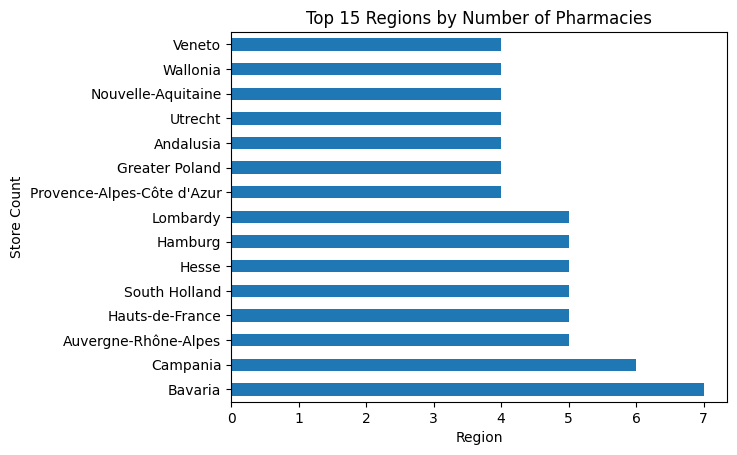

In [107]:
import matplotlib.pyplot as plt

region_counts = pharmacy_df["Region"].value_counts()

plt.figure()
region_counts.head(15).plot(kind="barh")
plt.title("Top 15 Regions by Number of Pharmacies")
plt.xlabel("Region")
plt.ylabel("Store Count")
plt.show()


In [105]:
# plot the region on a map chart using plotly
import plotly.express as px

fig = px.scatter_geo(
    pharmacy_df,
    lat="Latitude",
    lon="Longitude",
    color="Region",
    hover_name="PharmacyName_Clean",
    title="Pharmacy Locations Colored by Region"
)

fig.show()


**cities**

In [108]:
import pandas as pd

city_centers = (
    pharmacy_df.groupby(["City", "Country"])[["Latitude", "Longitude"]]
    .mean()
    .reset_index()
)

city_centers.head()


,City,Country,Latitude,Longitude
0,Amsterdam,Netherlands,52.380321,4.918529
1,Antwerp,Belgium,51.218543,4.396166
2,Arnhem,Netherlands,51.968768,5.902798
3,Barcelona,Spain,41.390016,2.173925
4,Berlin,Germany,52.523551,13.408219


In [110]:
fig = px.scatter_map(
    city_centers,
    lat="Latitude",
    lon="Longitude",
    hover_name="City",
    hover_data=["Country"],
    zoom=4,
    title="City Locations Covered in Dataset"
)

fig.update_traces(marker=dict(size=10, color="red"))

fig.update_layout(mapbox_style="satellite-streets")

fig.show()


**Store Size Band**

In [112]:
pharmacy_df["StoreSizeBand"].nunique()

3

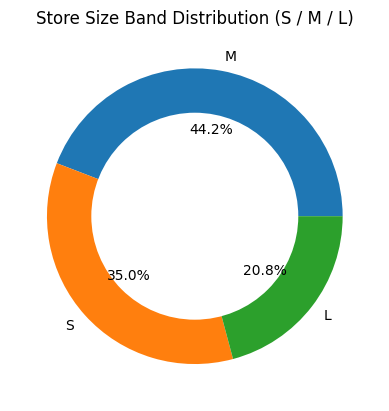

In [115]:
# plot a donut chart of store size band
import matplotlib.pyplot as plt

plt.figure()

# Pie chart
plt.pie(
    pharmacy_df["StoreSizeBand"].value_counts(),
    labels=pharmacy_df["StoreSizeBand"].value_counts().index,
    autopct="%1.1f%%"
)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
plt.gca().add_artist(centre_circle)

plt.title("Store Size Band Distribution (S / M / L)")
plt.show()


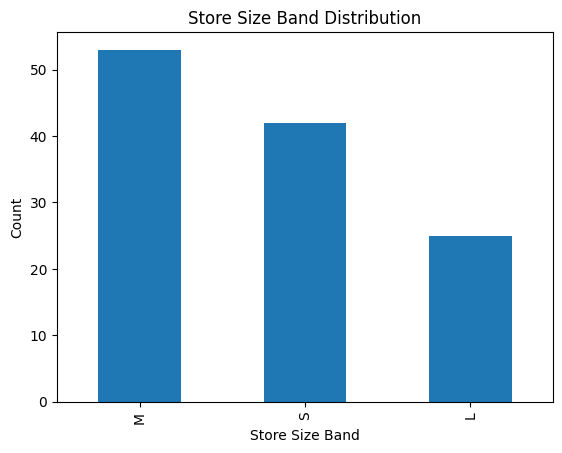

In [116]:
# plot a bar chart of store size band
pharmacy_df["StoreSizeBand"].value_counts().plot(kind="bar")
plt.title("Store Size Band Distribution")
plt.xlabel("Store Size Band")
plt.ylabel("Count")
plt.show()

In [122]:
# plot the store size band distribution by country using 100% stacked bar chart
import pandas as pd

country_size = (
    pharmacy_df.groupby(["Country", "StoreSizeBand"])
    .size()
    .unstack(fill_value=0)
)

print(country_size)


C:\Users\adith\AppData\Local\Temp\ipykernel_38252\3652990118.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



StoreSizeBand  L   M   S
Country                 
Austria        2   5   3
Belgium        5   5   4
France         3  10   7
Germany        4   8  10
Italy          4  11   3
Netherlands    2   6   3
Poland         3   4   6
Spain          2   4   6


In [123]:
country_size_pct = country_size.div(country_size.sum(axis=1), axis=0) * 100

print(country_size_pct)


StoreSizeBand          L          M          S
Country                                       
Austria        20.000000  50.000000  30.000000
Belgium        35.714286  35.714286  28.571429
France         15.000000  50.000000  35.000000
Germany        18.181818  36.363636  45.454545
Italy          22.222222  61.111111  16.666667
Netherlands    18.181818  54.545455  27.272727
Poland         23.076923  30.769231  46.153846
Spain          16.666667  33.333333  50.000000


<Figure size 640x480 with 0 Axes>

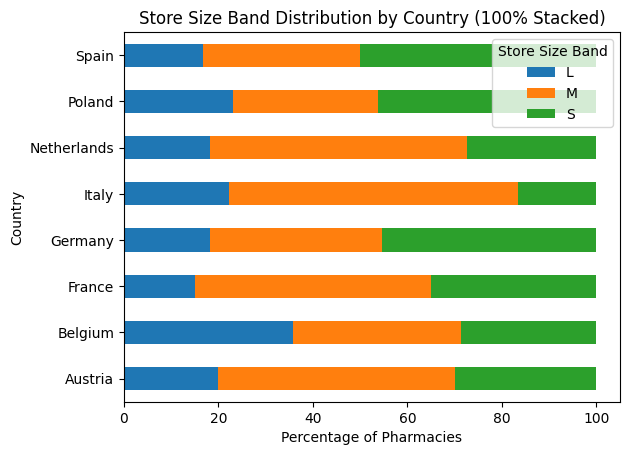

In [171]:
import matplotlib.pyplot as plt

plt.figure()

country_size_pct.plot(
    kind="barh",
    stacked=True
)

plt.title("Store Size Band Distribution by Country (100% Stacked)")
plt.xlabel("Percentage of Pharmacies")
plt.ylabel("Country")
plt.legend(title="Store Size Band")
plt.show()


In [127]:
region_size = (
    pharmacy_df.groupby(["Region", "StoreSizeBand"])
    .size()
    .unstack(fill_value=0)
)


C:\Users\adith\AppData\Local\Temp\ipykernel_38252\3417114258.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [134]:
region_size_pct = region_size.div(region_size.sum(axis=1), axis=0) * 100
region_size_pct_10 = region_size_pct.head(10)
print(region_size_pct_10)

StoreSizeBand                 L           M           S
Region                                                 
Andalusia              0.000000    0.000000  100.000000
Auvergne-Rhône-Alpes  20.000000   60.000000   20.000000
Basque Country        50.000000    0.000000   50.000000
Bavaria               14.285714   14.285714   71.428571
Berlin                 0.000000   66.666667   33.333333
Brussels-Capital      33.333333   33.333333   33.333333
Campania              16.666667   66.666667   16.666667
Catalonia              0.000000  100.000000    0.000000
Community of Madrid   33.333333   33.333333   33.333333
East Flanders          0.000000   66.666667   33.333333


<Figure size 640x480 with 0 Axes>

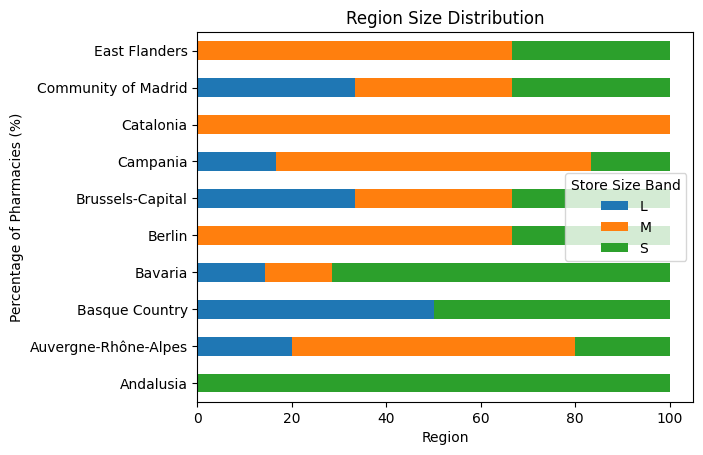

In [135]:
plt.figure()
region_size_pct_10.plot(kind='barh', stacked=True)
plt.title('Region Size Distribution')
plt.xlabel('Region')
plt.ylabel('Percentage of Pharmacies (%)')
plt.legend(title='Store Size Band')
plt.show()

In [136]:
city_size = (
    pharmacy_df
    .groupby(["City", "StoreSizeBand"])
    .size()
    .unstack(fill_value=0)
)
print(city_size)

StoreSizeBand  L  M  S
City                  
Amsterdam      0  1  0
Antwerp        1  0  1
Arnhem         0  0  1
Barcelona      0  3  0
Berlin         0  2  1
Bilbao         1  0  1
Bologna        0  1  0
Bordeaux       1  1  2
Bruges         0  2  0
Brussels       1  1  1
Cologne        0  2  0
Frankfurt      1  1  3
Gdańsk         0  2  1
Ghent          0  2  1
Graz           0  1  1
Hamburg        2  2  1
Innsbruck      0  1  0
Katowice       1  0  1
Kraków         2  0  0
Lille          0  3  2
Liège          3  0  1
Lyon           1  3  1
Madrid         1  1  1
Marseille      0  3  1
Milan          3  1  1
Munich         1  1  5
Naples         1  4  1
Paris          1  0  1
Poznań         0  1  3
Rome           0  2  0
Rotterdam      1  2  2
Salzburg       0  1  1
Seville        0  0  4
St. Pölten     1  0  1
Utrecht        1  3  0
Venice         0  3  1
Vienna         1  2  0
Warsaw         0  1  1


C:\Users\adith\AppData\Local\Temp\ipykernel_38252\880284255.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [138]:
city_size_pct = city_size.div(city_size.sum(axis=1), axis=0) * 100
city_size_pct_10 = city_size_pct.head(10)
print(city_size_pct_10)

StoreSizeBand          L           M           S
City                                            
Amsterdam       0.000000  100.000000    0.000000
Antwerp        50.000000    0.000000   50.000000
Arnhem          0.000000    0.000000  100.000000
Barcelona       0.000000  100.000000    0.000000
Berlin          0.000000   66.666667   33.333333
Bilbao         50.000000    0.000000   50.000000
Bologna         0.000000  100.000000    0.000000
Bordeaux       25.000000   25.000000   50.000000
Bruges          0.000000  100.000000    0.000000
Brussels       33.333333   33.333333   33.333333


<Figure size 640x480 with 0 Axes>

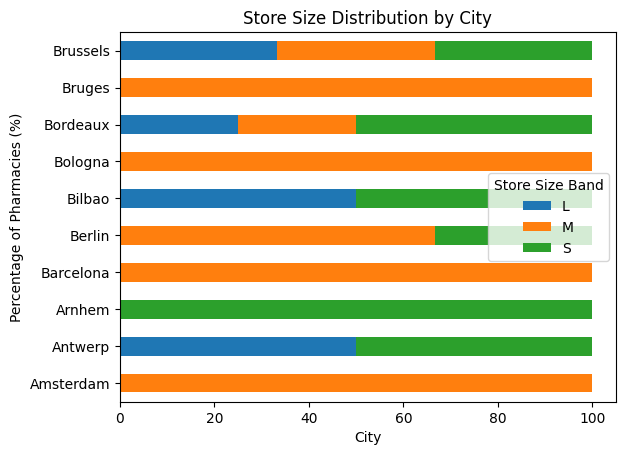

In [140]:
plt.figure()
city_size_pct_10.plot(
    kind="barh",
    stacked=True
    )
plt.title("Store Size Distribution by City")
plt.xlabel("City")
plt.ylabel("Percentage of Pharmacies (%)")
plt.legend(title="Store Size Band")
plt.show()

**Pharmacy Type**

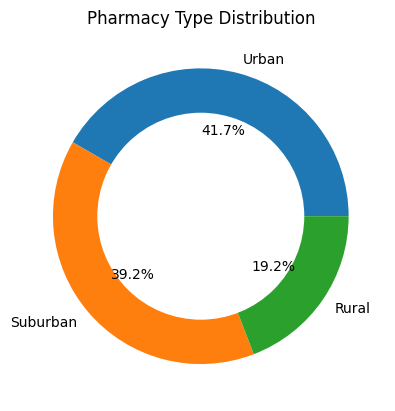

In [141]:
plt.figure()

# Pie chart
plt.pie(
    pharmacy_df["PharmacyType"].value_counts(),
    labels=pharmacy_df["PharmacyType"].value_counts().index,
    autopct="%1.1f%%"
)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
plt.gca().add_artist(centre_circle)

plt.title("Pharmacy Type Distribution")
plt.show()


In [151]:
country_type = (
    pharmacy_df
    .groupby(["Country", "PharmacyType"])
    .size()
    .unstack(fill_value=0)
)
print(country_type)

PharmacyType  Rural  Suburban  Urban
Country                             
Austria           0         6      4
Belgium           2         6      6
France            5        10      5
Germany           6        10      6
Italy             3         5     10
Netherlands       1         4      6
Poland            6         1      6
Spain             0         5      7


C:\Users\adith\AppData\Local\Temp\ipykernel_38252\564959948.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [156]:
country_type_pct = country_type.div(country_type.sum(axis=1), axis=0) * 100
country_type_10 = country_type_pct.head(10)
print(country_type_pct)

PharmacyType      Rural   Suburban      Urban
Country                                      
Austria        0.000000  60.000000  40.000000
Belgium       14.285714  42.857143  42.857143
France        25.000000  50.000000  25.000000
Germany       27.272727  45.454545  27.272727
Italy         16.666667  27.777778  55.555556
Netherlands    9.090909  36.363636  54.545455
Poland        46.153846   7.692308  46.153846
Spain          0.000000  41.666667  58.333333


<Figure size 640x480 with 0 Axes>

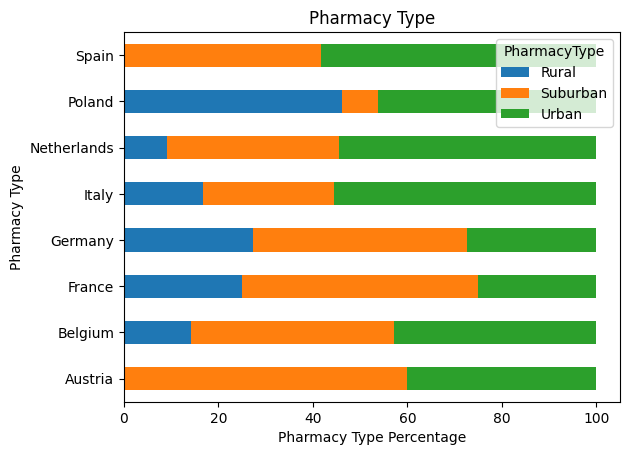

In [170]:
plt.figure()
country_type_10.plot(
    kind='barh',
    stacked = True,
    title = 'Pharmacy Type'

)
plt.xlabel('Pharmacy Type Percentage')
plt.ylabel('Pharmacy Type')
plt.show()

In [154]:
region_type = (
    pharmacy_df.groupby(["Region", "PharmacyType"])
    .size()
    .unstack(fill_value=0)
)
print(region_type)

PharmacyType                Rural  Suburban  Urban
Region                                            
Andalusia                       0         3      1
Auvergne-Rhône-Alpes            1         2      2
Basque Country                  0         1      1
Bavaria                         2         3      2
Berlin                          0         2      1
Brussels-Capital                1         1      1
Campania                        2         1      3
Catalonia                       0         1      2
Community of Madrid             0         0      3
East Flanders                   0         2      1
Emilia-Romagna                  0         1      0
Flanders                        0         1      1
Gelderland                      0         1      0
Greater Poland                  1         0      3
Hamburg                         1         3      1
Hauts-de-France                 0         4      1
Hesse                           1         2      2
Lazio                          

C:\Users\adith\AppData\Local\Temp\ipykernel_38252\950299121.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [158]:
region_type_pct = region_type.div(region_type.sum(axis=1), axis=0) * 100
region_type_10 = region_type_pct.head(10)
print(region_type_10)

PharmacyType              Rural   Suburban       Urban
Region                                                
Andalusia              0.000000  75.000000   25.000000
Auvergne-Rhône-Alpes  20.000000  40.000000   40.000000
Basque Country         0.000000  50.000000   50.000000
Bavaria               28.571429  42.857143   28.571429
Berlin                 0.000000  66.666667   33.333333
Brussels-Capital      33.333333  33.333333   33.333333
Campania              33.333333  16.666667   50.000000
Catalonia              0.000000  33.333333   66.666667
Community of Madrid    0.000000   0.000000  100.000000
East Flanders          0.000000  66.666667   33.333333


<Figure size 640x480 with 0 Axes>

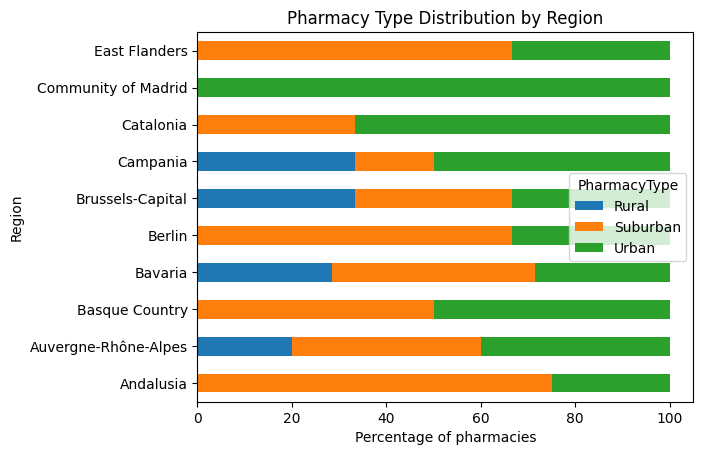

In [167]:
plt.figure()
region_type_10.plot(kind="barh", stacked=True)
plt.title("Pharmacy Type Distribution by Region")
plt.xlabel("Percentage of pharmacies")
plt.ylabel("Region")
plt.show()

In [162]:
city_type = (
    pharmacy_df.groupby(["City", "PharmacyType"])
    .size()
    .unstack(fill_value=0)
)
print(city_type)

PharmacyType  Rural  Suburban  Urban
City                                
Amsterdam         0         0      1
Antwerp           0         1      1
Arnhem            0         1      0
Barcelona         0         1      2
Berlin            0         2      1
Bilbao            0         1      1
Bologna           0         1      0
Bordeaux          2         1      1
Bruges            0         0      2
Brussels          1         1      1
Cologne           2         0      0
Frankfurt         1         2      2
Gdańsk            1         0      2
Ghent             0         2      1
Graz              0         2      0
Hamburg           1         3      1
Innsbruck         0         0      1
Katowice          1         1      0
Kraków            1         0      1
Lille             0         4      1
Liège             1         2      1
Lyon              1         2      2
Madrid            0         0      3
Marseille         0         3      1
Milan             0         1      4
M

C:\Users\adith\AppData\Local\Temp\ipykernel_38252\3333653505.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [163]:
city_type_pct = city_type.div(city_type.sum(axis=1), axis=0)
city_type_10 = city_type_pct.head(10)
print(city_type_10)

PharmacyType     Rural  Suburban     Urban
City                                      
Amsterdam     0.000000  0.000000  1.000000
Antwerp       0.000000  0.500000  0.500000
Arnhem        0.000000  1.000000  0.000000
Barcelona     0.000000  0.333333  0.666667
Berlin        0.000000  0.666667  0.333333
Bilbao        0.000000  0.500000  0.500000
Bologna       0.000000  1.000000  0.000000
Bordeaux      0.500000  0.250000  0.250000
Bruges        0.000000  0.000000  1.000000
Brussels      0.333333  0.333333  0.333333


<Figure size 640x480 with 0 Axes>

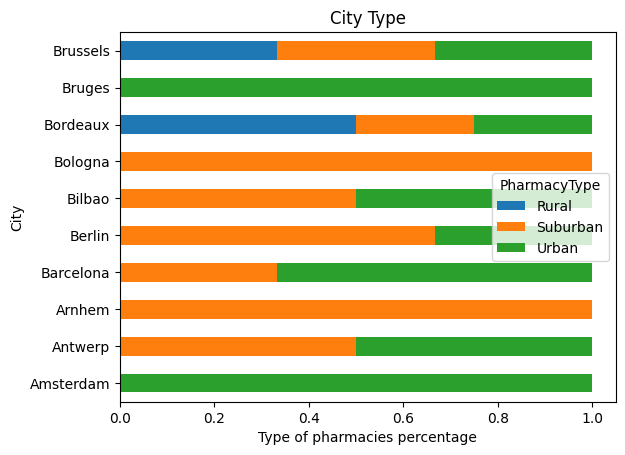

In [166]:
plt.figure()
city_type_10.plot(kind="barh", stacked=True)
plt.xlabel("Type of pharmacies percentage")
plt.ylabel("City")
plt.title("City Type")
plt.show()

#### DimPharmacy Table Documentation

##### Overview
The `DimPharmacy` table contains descriptive information about each pharmacy location in the distributor network.

- Rows: 120 (one row per pharmacy)
- Columns: 10
- Primary Key: `PharmacyID`

This table supports geographic drilldowns and segmentation by store characteristics such as pharmacy type and store size.

---

##### Columns

- **PharmacyID**: Unique identifier for each pharmacy  
- **PharmacyName**: Store name with appended numeric suffix  
- **Country / Region / City**: Geographic hierarchy for drilldowns  
- **PharmacyType**: Urban / Suburban / Rural classification  
- **OpenDate**: Store opening date  
- **StoreSizeBand**: Store size category (S / M / L)  
- **Latitude / Longitude**: Coordinates for mapping visuals  

---

##### Data Quality Checks

- No missing values across all 120 pharmacies  
- Latitude and Longitude are correctly stored as float values  
- All other columns are stored as objects and may require type conversion later

---

##### Feature Engineering: PharmacyName Cleaning

All pharmacy names contain a redundant numeric suffix (e.g., `#001`).

A cleaned display column was created:

- `PharmacyName_Clean`

Example:

Naples HealthPoint #001 → Naples HealthPoint

---

##### Distribution Insights (Descriptive)

##### PharmacyType Counts
- Urban: 50  
- Suburban: 47  
- Rural: 23  

##### Region Coverage
The dataset spans 8 countries and multiple European regions, with Bavaria (7) and Campania (6) having the highest store counts.

##### Store Size Band Mix
Store sizes are categorized into S, M, and L, with noticeable variation in composition across countries.

---

##### Visual Profiling Included
- Country scope map (8-country coverage)
- Top regions by pharmacy count
- City locator map
- Store size distribution (overall + by country)
- Pharmacy type distribution (overall + by country)

---

##### Next Step
DimPharmacy will later be joined with `FactSales` to evaluate revenue and margin performance by:

- Country → Region → Pharmacy  
- Urban vs Suburban vs Rural stores  
- Store size impact on sales and profitability  


#### DimProduct Table Documentation

##### Overview
The `DimProduct` table contains descriptive attributes for each product sold across the pharmacy network.

Each row represents:

**One unique product SKU**

- Rows: 220 products
- Primary Key: `ProductID`

This table enables analysis of product performance across:

- Categories and brands
- Generic vs non-generic products
- Pricing vs cost structure
- Product lifecycle (launch/discontinuation)

---

##### Columns

- **ProductID**: Unique product identifier (links to FactSales)
- **ProductName**: Full product name
- **Category**: High-level product grouping (e.g., OTC, Personal Care)
- **Brand**: Product brand name
- **IsGeneric**: Generic vs branded indicator
- **PackSize**: Package description (e.g., 30 tablets, 200 ml)
- **ListPriceEUR**: Listed selling price per unit
- **StandardCostEUR**: Standard cost per unit
- **LaunchDate**: Product introduction date
- **IsDiscontinued**: Discontinuation status
- **DiscontinuedDate**: Date product was discontinued (if applicable)


In [5]:
product_df.head()

,ProductID,ProductName,Category,Brand,IsGeneric,PackSize,ListPriceEUR,StandardCostEUR,LaunchDate,IsDiscontinued,DiscontinuedDate
0,PR0001,CareEquip Glucose Test Strips Compact,Medical Devices,CareEquip,No,1 unit,10.14,8.19,2018-04-09,No,NaN
1,PR0002,Medica Nasal Spray 100 mg,OTC,Medica,No,200 ml,7.03,5.52,2015-08-21,No,NaN
2,PR0003,VitaCare Vitamin C 100 mg,OTC,VitaCare,No,30 tablets,13.42,10.69,2022-11-22,No,NaN
3,PR0004,DermaSoft Shampoo Repair,Personal Care,DermaSoft,No,100 ml,15.13,8.83,2018-01-10,No,NaN
4,PR0005,CleanWave Moisturizer Sensitive,Personal Care,CleanWave,No,250 ml,14.29,10.56,2025-08-11,No,NaN


**Basic inspection**

In [6]:
product_df.shape

(220, 11)

In [7]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ProductID         220 non-null    object 
 1   ProductName       220 non-null    object 
 2   Category          220 non-null    object 
 3   Brand             220 non-null    object 
 4   IsGeneric         220 non-null    object 
 5   PackSize          220 non-null    object 
 6   ListPriceEUR      220 non-null    float64
 7   StandardCostEUR   220 non-null    float64
 8   LaunchDate        220 non-null    object 
 9   IsDiscontinued    220 non-null    object 
 10  DiscontinuedDate  35 non-null     object 
dtypes: float64(2), object(9)
memory usage: 19.0+ KB


**Primary key Validation**

In [9]:
product_df["ProductID"].nunique() == len(product_df)

True

In [23]:
product_df["ProductID"].nunique()

220

**Missing Values Check**

In [10]:
product_df.isnull().sum()

ProductID             0
ProductName           0
Category              0
Brand                 0
IsGeneric             0
PackSize              0
ListPriceEUR          0
StandardCostEUR       0
LaunchDate            0
IsDiscontinued        0
DiscontinuedDate    185
dtype: int64

**Convert Date Columns**

In [11]:
product_df["LaunchDate"] = pd.to_datetime(product_df["LaunchDate"])

In [12]:
product_df["DiscontinuedDate"] = pd.to_datetime(product_df["DiscontinuedDate"])

**Category + Brand Coverage**

In [13]:
product_df["Category"].value_counts()

Category
OTC                61
Prescription       47
Personal Care      47
Wellness           41
Medical Devices    24
Name: count, dtype: int64

In [14]:
product_df["Category"].value_counts().head(10)

Category
OTC                61
Prescription       47
Personal Care      47
Wellness           41
Medical Devices    24
Name: count, dtype: int64

In [15]:
product_df["Brand"].value_counts().head(10)

Brand
Medica         12
PainLess       11
SmileBright    11
EuroRelief     10
AntiBioX       10
BioBalance     10
FreshLine      10
ColdAway        8
AllerFree       8
GlucoSafe       8
Name: count, dtype: int64

**Generic vs Branded Split**

In [16]:
product_df["IsGeneric"].value_counts(normalize=True) * 100


IsGeneric
No     85.0
Yes    15.0
Name: proportion, dtype: float64

**Pricing vs Cost Sanity Check**

In [17]:
(product_df["StandardCostEUR"] > product_df["ListPriceEUR"]).sum()


np.int64(0)

**Product Lifecycle Profiling**

In [18]:
product_df["IsDiscontinued"].value_counts()

IsDiscontinued
No     185
Yes     35
Name: count, dtype: int64

In [19]:
product_df["LaunchYear"] = product_df["LaunchDate"].dt.year
product_df["LaunchYear"].value_counts().sort_index()


LaunchYear
2015    16
2016    23
2017    27
2018    23
2019    18
2020    22
2021    10
2022    11
2023    23
2024    25
2025    22
Name: count, dtype: int64

##### 1. Product Name 

In [21]:
product_df["ProductName"].value_counts()

ProductName
GlucoMeterX Digital Thermometer Smart    2
DermaSoft Moisturizer Classic            2
ImmunoPlus Multivitamin Max              2
SmileBright Shampoo Repair               2
BioBalance Collagen Pure                 2
                                        ..
MediTech Blood Pressure Monitor Smart    1
GlucoSafe Insulin Pen 20 mg              1
PainLess Antacid 20 mg                   1
GlucoSafe Antibiotic 10 mg               1
HairEssence Mouthwash Hydra              1
Name: count, Length: 203, dtype: int64

In [22]:
product_df["ProductName"].nunique()

203

In [24]:
product_df["ProductName"].duplicated().sum()

np.int64(17)

In [25]:
# print the duplicate product names
product_df[product_df["ProductName"].duplicated()]

# print the duplicate product names with their counts
product_df[product_df["ProductName"].duplicated()].groupby("ProductName").size().sort_values(ascending=False)



ProductName
AntiBioX ACE Inhibitor 400 mg            1
BioBalance Collagen Pure                 1
CardioPro Corticosteroid Cream 20 mg     1
ColdAway Paracetamol 200 mg              1
DermRx Insulin Pen 200 mg                1
DermaSoft Moisturizer Classic            1
DigestEase Nasal Spray 200 mg            1
FreshLine Mouthwash Sensitive            1
GlucoMeterX Digital Thermometer Smart    1
ImmunoPlus Multivitamin Max              1
Medica Vitamin C 10 mg                   1
NeuroMed Antidepressant 100 mg           1
NutriCore Magnesium Max                  1
PainLess Throat Lozenges 20 mg           1
SmileBright Hand Cream Classic           1
SmileBright Shampoo Repair               1
ZenHealth Probiotic Daily                1
dtype: int64

##### 2. Product Category

In [27]:
product_df["Category"].value_counts()

Category
OTC                61
Prescription       47
Personal Care      47
Wellness           41
Medical Devices    24
Name: count, dtype: int64

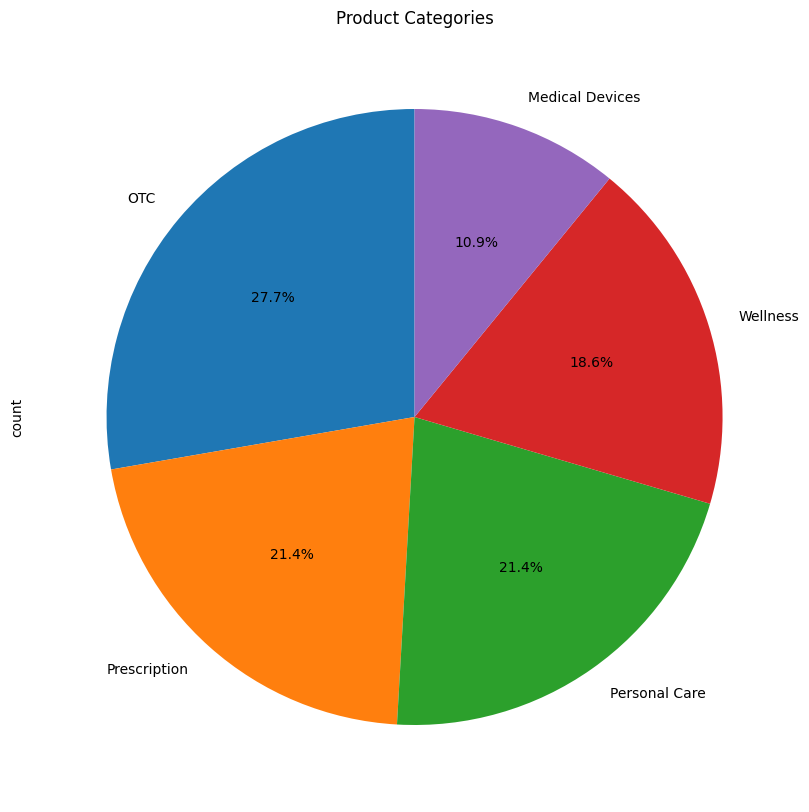

In [29]:
# plot a donut chart of product categories
import matplotlib.pyplot as plt
product_df["Category"].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90, figsize=(10, 10), title="Product Categories")
plt.show()


#### 3. Product Brand

In [30]:
product_df["Brand"].nunique()

32

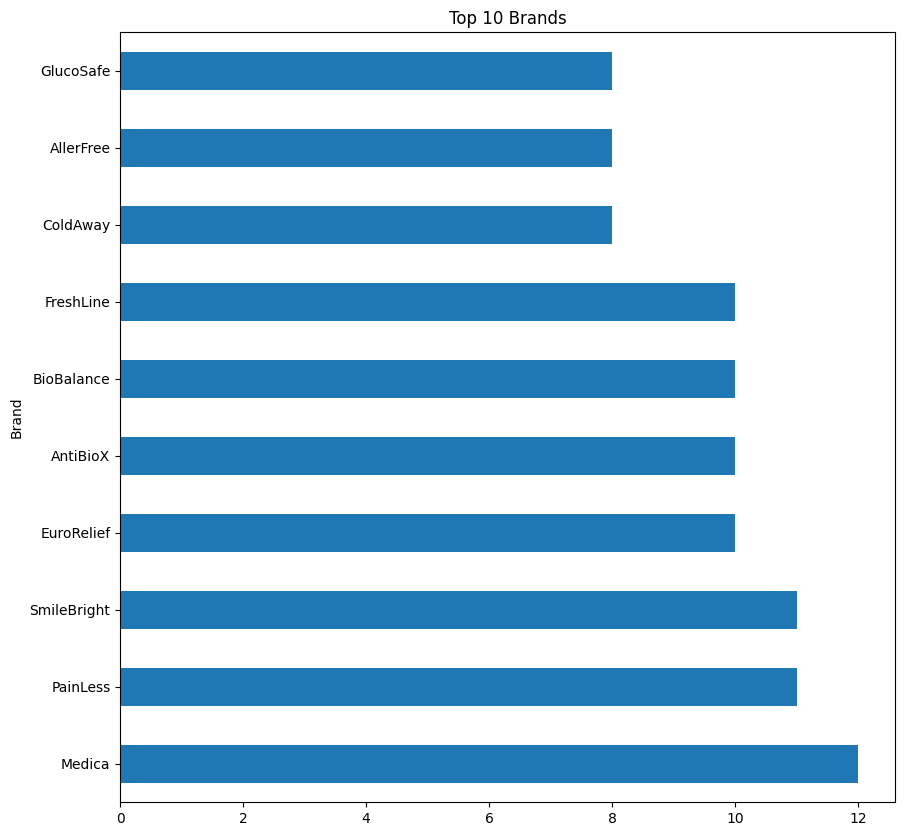

In [31]:
# plot top 10 brands
product_df["Brand"].value_counts().head(10).plot(kind="barh", figsize=(10, 10), title="Top 10 Brands")
plt.show()

In [32]:
brand_counts = product_df["Brand"].value_counts()

print(brand_counts.head(10))
print("Total brands:", brand_counts.shape[0])


Brand
Medica         12
PainLess       11
SmileBright    11
EuroRelief     10
AntiBioX       10
BioBalance     10
FreshLine      10
ColdAway        8
AllerFree       8
GlucoSafe       8
Name: count, dtype: int64
Total brands: 32


**Brand Share % (Better than raw counts)**

In [33]:
brand_share = brand_counts / brand_counts.sum() * 100
print(brand_share.head(10))

Brand
Medica         5.454545
PainLess       5.000000
SmileBright    5.000000
EuroRelief     4.545455
AntiBioX       4.545455
BioBalance     4.545455
FreshLine      4.545455
ColdAway       3.636364
AllerFree      3.636364
GlucoSafe      3.636364
Name: count, dtype: float64


**Cumulative Share (Pareto / 80/20 Test)**

In [34]:
pareto = brand_share.cumsum()

pareto.head(15)


Brand
Medica          5.454545
PainLess       10.454545
SmileBright    15.454545
EuroRelief     20.000000
AntiBioX       24.545455
BioBalance     29.090909
FreshLine      33.636364
ColdAway       37.272727
AllerFree      40.909091
GlucoSafe      44.545455
DermaSoft      48.181818
HairEssence    51.818182
ImmunoPlus     55.454545
VitaCare       59.090909
DermRx         62.272727
Name: count, dtype: float64

In [35]:
pareto[pareto <= 80].count()


np.int64(21)

**Pareto Chart**

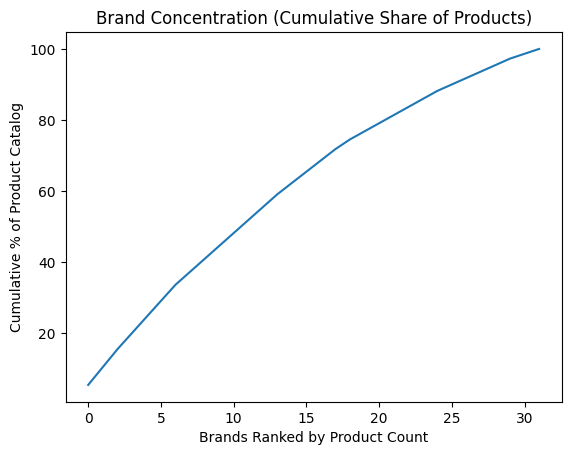

In [36]:
plt.figure()
plt.plot(pareto.values)

plt.title("Brand Concentration (Cumulative Share of Products)")
plt.xlabel("Brands Ranked by Product Count")
plt.ylabel("Cumulative % of Product Catalog")
plt.show()


**Shannon Diversity Index (Advanced, Optional Winner Move)**

In [37]:
import numpy as np

p = brand_counts / brand_counts.sum()
shannon = -(p * np.log(p)).sum()

print("Shannon Diversity Index:", shannon)


Shannon Diversity Index: 3.398348250128728


**Pack Size**

In [38]:
product_df["PackSize"].value_counts()

PackSize
100 ml         25
30 tablets     20
400 ml         12
500 g          12
50 g           11
10 tablets     10
20 tablets     10
150 ml          9
250 g           9
60 capsules     8
1 pen           8
250 ml          8
90 tablets      8
90 capsules     8
60 tablets      8
200 ml          7
15 lozenges     7
1 unit          7
25 strips       7
5 pens          6
50 strips       6
75 ml           6
10 strips       4
30 capsules     4
Name: count, dtype: int64

In [39]:
product_df["PackSize"].nunique()

24

**IsGeneric**

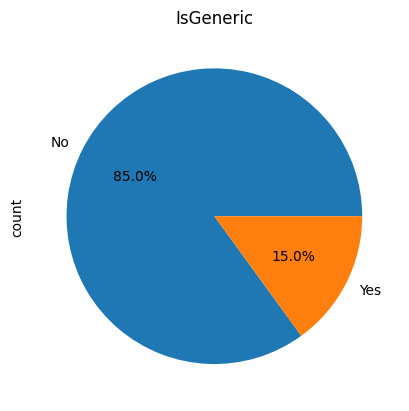

In [40]:
# plot a pie chart of IsGeneric
product_df["IsGeneric"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("IsGeneric")
plt.show()

**ListPriceEUR vs StandardPriceEUR**

(Pricing Structure + Margin Potential)

these two together answer:

1. Are products priced consistently above cost?

2. Which products have high markup vs low markup?

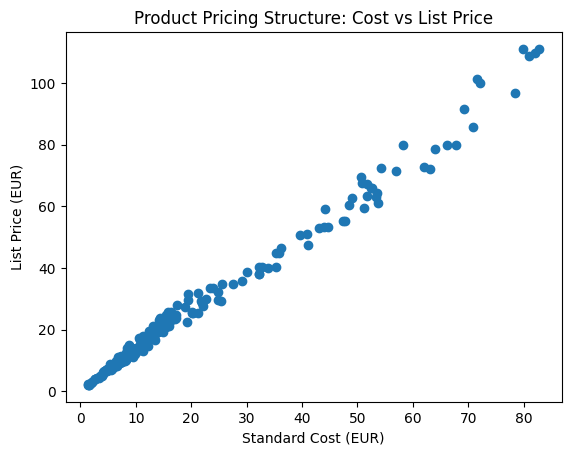

In [41]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    product_df["StandardCostEUR"],
    product_df["ListPriceEUR"]
)

plt.title("Product Pricing Structure: Cost vs List Price")
plt.xlabel("Standard Cost (EUR)")
plt.ylabel("List Price (EUR)")
plt.show()


**Interpretation**

1. Points close to diagonal -> low margin products

2. Points far from diagonal -> high margin products

**Add Derived Metric: Potential Unit Margin**

In [42]:
product_df["UnitMargin"] = product_df["ListPriceEUR"] - product_df["StandardCostEUR"]
product_df["UnitMarginPct"] = product_df["UnitMargin"] / product_df["ListPriceEUR"]


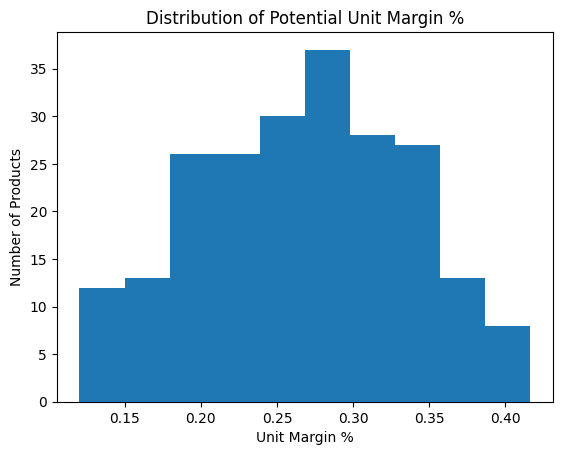

In [44]:
plt.figure()
plt.hist(product_df["UnitMarginPct"])
plt.title("Distribution of Potential Unit Margin %")
plt.xlabel("Unit Margin %")
plt.ylabel("Number of Products")
plt.show()


**LaunchDate**

(product lifecycle + portfolio freshness)

LaunchDate -> Is the catalog mostly old or recently refreshed?

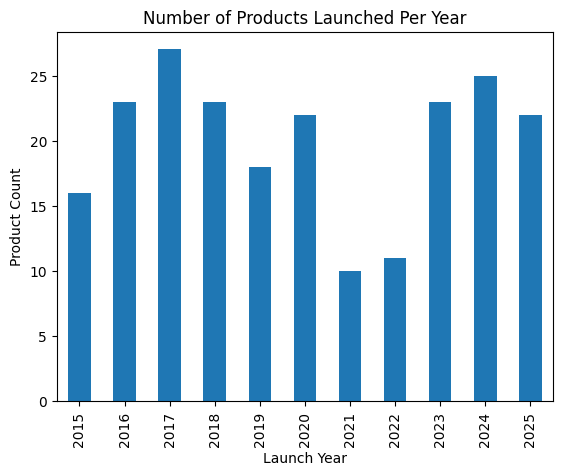

In [45]:
product_df["LaunchYear"] = product_df["LaunchDate"].dt.year

launch_counts = product_df["LaunchYear"].value_counts().sort_index()

plt.figure()
launch_counts.plot(kind="bar")

plt.title("Number of Products Launched Per Year")
plt.xlabel("Launch Year")
plt.ylabel("Product Count")
plt.show()


**Pricing by category**

(Category-Level Strategy)

Price/cost is meaningless without category context

this answers which categories are premium 

and which are low-cost commodity

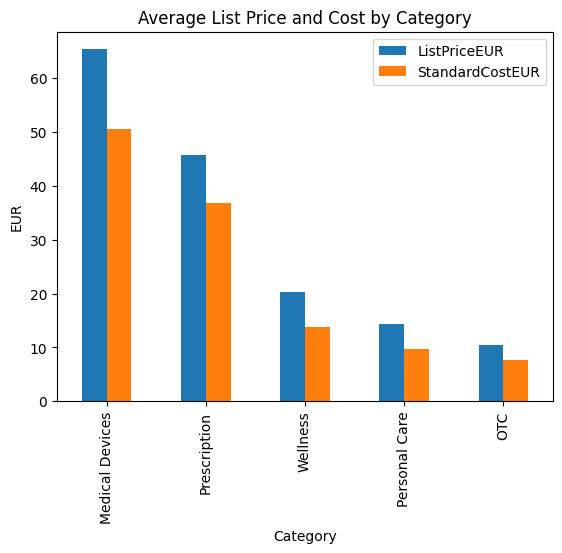

In [46]:
category_price = (
    product_df.groupby("Category")[["ListPriceEUR", "StandardCostEUR"]]
    .mean()
    .sort_values("ListPriceEUR", ascending=False)
)

category_price.plot(kind="bar")

plt.title("Average List Price and Cost by Category")
plt.ylabel("EUR")
plt.show()


**Unit Margin by Brand**

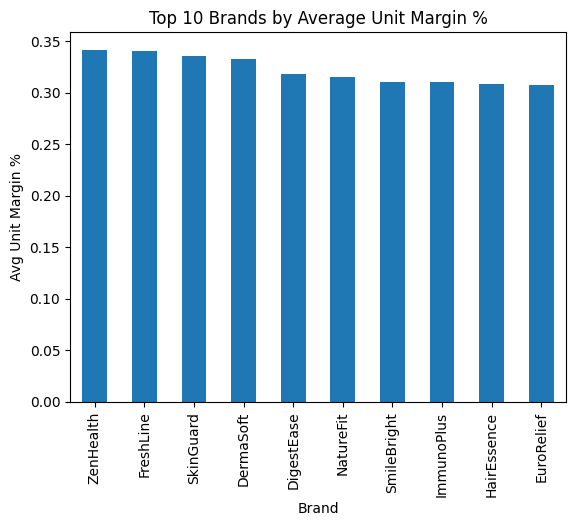

In [47]:
brand_margin = (
    product_df.groupby("Brand")["UnitMarginPct"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
brand_margin.plot(kind="bar")

plt.title("Top 10 Brands by Average Unit Margin %")
plt.ylabel("Avg Unit Margin %")
plt.show()


##### 📈 Feature Plot & Business Insight Matrix

| Feature | Plot Type | Business Insight |
|---------|-----------|------------------|
| **ListPrice vs Cost** | Scatter | Margin potential + anomalies |
| **UnitMarginPct** | Histogram | Portfolio profitability distribution |
| **LaunchDate** | Launch/year bar | Innovation vs legacy catalog |
| **Category price/cost** | Grouped bar | Premium vs commodity categories |

**isDiscontinued**

In [49]:
product_df['IsDiscontinued'].nunique()

2

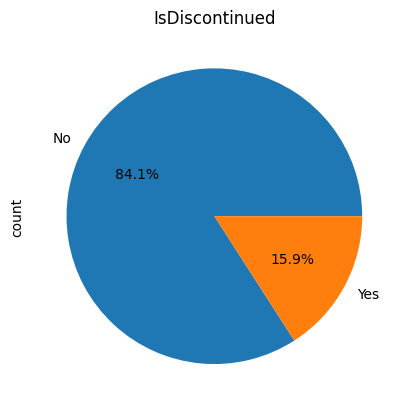

In [50]:
# plot IsDiscontinued using pie chart
product_df['IsDiscontinued'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('IsDiscontinued')
plt.show()

In [51]:
(product_df['IsDiscontinued'] == "Yes").value_counts() 

IsDiscontinued
False    185
True      35
Name: count, dtype: int64

#### DimProduct Table Documentation

##### Overview
The `DimProduct` table contains descriptive attributes for each product sold in the pharmacy distributor network.

Each row represents one unique product SKU.

- Rows: 220  
- Columns: 11  
- Primary Key: `ProductID`

This dimension enables product-level drilldowns across:

- Category → Brand → Product
- Generic vs branded products
- Pricing and cost structure
- Product lifecycle (launch and discontinuation)

---

##### Column Summary

- **ProductID**: Unique identifier for each product (joins to FactSales)
- **ProductName**: Full product description
- **Category**: High-level grouping (OTC, Prescription, etc.)
- **Brand**: Brand name (32 total brands)
- **IsGeneric**: Generic indicator (Yes/No)
- **PackSize**: Packaging format (e.g., 100 ml, 30 tablets)
- **ListPriceEUR**: Listed unit price
- **StandardCostEUR**: Standard unit cost
- **LaunchDate**: Product introduction date
- **IsDiscontinued**: Discontinued flag
- **DiscontinuedDate**: Only populated for discontinued products

---

##### Data Quality Checks

- No missing values in core descriptive columns
- DiscontinuedDate has 185 null values, expected since most products are active
- LaunchDate and DiscontinuedDate require datetime conversion for time-based analysis

---

##### Category Distribution

| Category            | Products |
|---------------------|----------|
| OTC                 | 61       |
| Prescription        | 47       |
| Personal Care       | 47       |
| Wellness            | 41       |
| Medical Devices     | 24       |

OTC is the largest category (~28% of the catalog).

---

##### Brand Coverage & Diversity

- Total brands: 32
- Top brand (Medica): 12 products (~5.5% of catalog)

Brand concentration is moderate:
- 21 brands account for 80% of all products (Pareto test)

Shannon Diversity Index: **3.40**, indicating a fairly diverse product portfolio.

---

##### Generic vs Branded Split

- Non-generic products: 85%
- Generic products: 15%

---

##### Product Lifecycle

- Active products: 185
- Discontinued products: 35 (~16%)

Launch years range from 2015–2025, with consistent product introductions each year.

---

##### Pricing Structure

List price vs standard cost shows strong alignment with expected markup patterns.

Potential unit margin % distribution is centered roughly around 25–35%.

---

##### Notes

Some ProductName duplicates exist (17 duplicated names), which may reflect different SKUs or packaging variations.
ProductID remains the true unique key.

---

##### Next Step

DimProduct will later be joined with FactSales to analyze:

- Revenue and margin contribution by category and brand
- High-volume vs high-margin products
- Promotion impact across product groups


In [53]:
date_df.shape

(731, 7)

In [54]:
date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateKey      731 non-null    int64         
 1   Date         731 non-null    datetime64[ns]
 2   Year         731 non-null    int64         
 3   Quarter      731 non-null    int64         
 4   MonthNumber  731 non-null    int64         
 5   MonthName    731 non-null    object        
 6   YearMonth    731 non-null    object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 40.1+ KB


In [55]:
date_df.head()

,DateKey,Date,Year,Quarter,MonthNumber,MonthName,YearMonth
0,20240101,2024-01-01,2024,1,1,January,2024-01
1,20240102,2024-01-02,2024,1,1,January,2024-01
2,20240103,2024-01-03,2024,1,1,January,2024-01
3,20240104,2024-01-04,2024,1,1,January,2024-01
4,20240105,2024-01-05,2024,1,1,January,2024-01


In [56]:
date_df["Date"] = pd.to_datetime(date_df["Date"])

In [57]:
date_df["Date"].min()

Timestamp('2024-01-01 00:00:00')

In [58]:
date_df["Date"].max()

Timestamp('2025-12-31 00:00:00')

In [59]:
date_df["DateKey"].nunique() == len(date_df)

True

In [60]:
date_df["MonthName"].value_counts()

MonthName
January      62
March        62
July         62
May          62
December     62
October      62
August       62
April        60
September    60
June         60
November     60
February     57
Name: count, dtype: int64

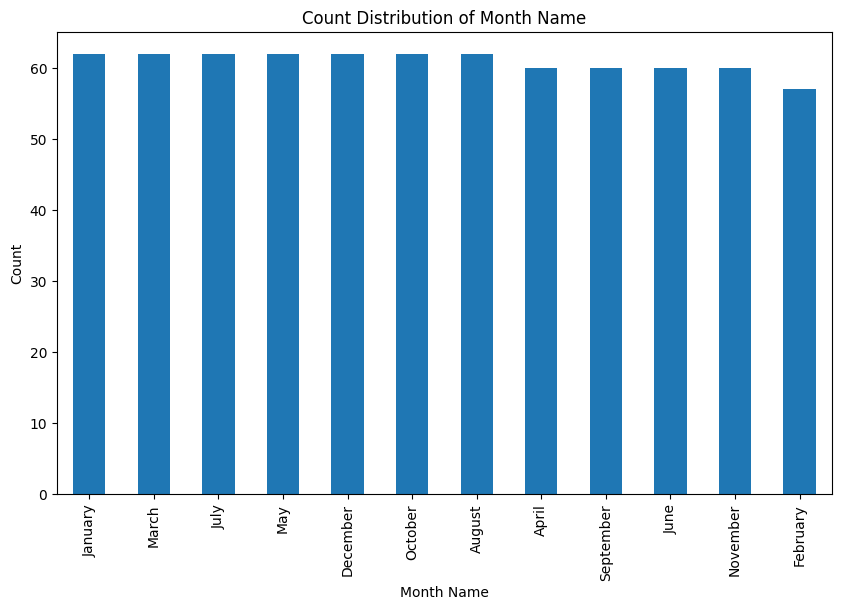

In [62]:
# plot a bar chart of count distribution of month name 
plt.figure(figsize=(10, 6))
date_df["MonthName"].value_counts().plot(kind="bar")
plt.title("Count Distribution of Month Name")
plt.xlabel("Month Name")
plt.ylabel("Count")
plt.show()

In [61]:
date_df["Quarter"].value_counts()

Quarter
4    184
3    184
2    182
1    181
Name: count, dtype: int64

#### DimDate Table Documentation

##### Overview
The `DimDate` table provides the calendar/time dimension for the dataset.

Each row represents **one unique day**, enabling time-based analysis such as:

- Revenue and margin trends over time  
- Monthly seasonality patterns  
- Year-over-year comparisons  
- Drilldown: Year → Quarter → Month → Date  

---

##### Dataset Summary

- Rows: 731 (covers 2 full years)
- Columns: 7
- Primary Key: DateKey

---

##### Column Structure

- **DateKey**: Integer key in YYYYMMDD format  
- **Date**: Actual calendar date (datetime)  
- **Year**: Year value (2024–2025)  
- **Quarter**: Quarter number (1–4)  
- **MonthNumber**: Month number (1–12)  
- **MonthName**: Month name (January–December)  
- **YearMonth**: Year-month grouping (e.g., 2024-01)

---

##### Coverage Validation

- Start Date: 2024-01-01  
- End Date: 2025-12-31  

This confirms the dataset spans **two complete years**.

---

##### Month & Quarter Distribution Check

Month counts vary slightly due to different month lengths:

- February has the fewest days (57 across two years)
- Months with 31 days appear 62 times

Quarter distribution is balanced (~181–184 days each).

---

##### Notes

DimDate is clean, complete, and ready to support time intelligence in Power BI
(e.g., YoY growth, monthly seasonality, quarterly trends).


#### Table Join

In [63]:
sales_df.head()

,SalesID,DateKey,PharmacyID,ProductID,UnitsSold,RevenueEUR,CostEUR,MarginEUR,PromoFlag
0,S0000001,20240101,PH0002,PR0099,5,128.08,87.55,40.53,No
1,S0000002,20240101,PH0004,PR0156,4,51.89,34.32,17.57,No
2,S0000003,20240101,PH0007,PR0004,20,317.73,199.53,118.20,No
3,S0000004,20240101,PH0009,PR0075,6,90.34,67.49,22.85,No
4,S0000005,20240101,PH0010,PR0154,2,160.21,124.99,35.22,Yes


In [64]:
product_df.head()

,ProductID,ProductName,Category,Brand,IsGeneric,PackSize,ListPriceEUR,StandardCostEUR,LaunchDate,IsDiscontinued,DiscontinuedDate,LaunchYear,UnitMargin,UnitMarginPct
0,PR0001,CareEquip Glucose Test Strips Compact,Medical Devices,CareEquip,No,1 unit,10.14,8.19,2018-04-09,No,NaT,2018,1.95,0.192308
1,PR0002,Medica Nasal Spray 100 mg,OTC,Medica,No,200 ml,7.03,5.52,2015-08-21,No,NaT,2015,1.51,0.214794
2,PR0003,VitaCare Vitamin C 100 mg,OTC,VitaCare,No,30 tablets,13.42,10.69,2022-11-22,No,NaT,2022,2.73,0.203428
3,PR0004,DermaSoft Shampoo Repair,Personal Care,DermaSoft,No,100 ml,15.13,8.83,2018-01-10,No,NaT,2018,6.30,0.416391
4,PR0005,CleanWave Moisturizer Sensitive,Personal Care,CleanWave,No,250 ml,14.29,10.56,2025-08-11,No,NaT,2025,3.73,0.261022


In [65]:
pharmacy_df.head()

,PharmacyID,PharmacyName,Country,Region,City,PharmacyType,OpenDate,StoreSizeBand,Latitude,Longitude
0,PH0001,Naples HealthPoint #001,Italy,Campania,Naples,Suburban,2025-04-03,M,40.839137,14.279288
1,PH0002,Innsbruck HealthPoint #002,Austria,Tyrol,Innsbruck,Urban,2011-12-21,M,47.254915,11.410136
2,PH0003,Barcelona HealthPoint #003,Spain,Catalonia,Barcelona,Urban,2025-04-20,M,41.386090,2.170678
3,PH0004,Katowice HealthPoint #004,Poland,Silesian,Katowice,Suburban,2018-07-18,L,50.260198,19.043129
4,PH0005,Poznań HealthPoint #005,Poland,Greater Poland,Poznań,Urban,2021-07-12,S,52.408932,16.920617


In [66]:
date_df.head()

,DateKey,Date,Year,Quarter,MonthNumber,MonthName,YearMonth
0,20240101,2024-01-01,2024,1,1,January,2024-01
1,20240102,2024-01-02,2024,1,1,January,2024-01
2,20240103,2024-01-03,2024,1,1,January,2024-01
3,20240104,2024-01-04,2024,1,1,January,2024-01
4,20240105,2024-01-05,2024,1,1,January,2024-01


##### 🌟 Star Schema Structure

##### Fact Table (Transactions)
**FactSales**

Each row = one sale event:
- **what** was sold (`ProductID`)
- **where** it was sold (`PharmacyID`)
- **when** it was sold (`DateKey`)
- **how much** (`Revenue`, `Margin`, `Units`)

---

##### Dimension Tables (Descriptions)

| Dimension | Key Column | Adds Context |
|-----------|------------|--------------|
| **DimDate** | DateKey | Year, Month, Quarter |
| **DimPharmacy** | PharmacyID | Country, Region, Type |
| **DimProduct** | ProductID | Category, Brand, Generic |

---

##### ✅ Join Rule (Most Important)

**FactSales** contains **FOREIGN KEYS**  
**Dimensions** contain **PRIMARY KEYS**

So we always join like this:
```sql
FactSales LEFT JOIN Dimension
```

##### Why LEFT JOIN?

Because:
- We want to keep every transaction
- Even if dimension info is missing (shouldn't happen, but safe)

---

##### ✅ The 3 Joins

**FactSales** has 3 ID columns:
```sql
DateKey      → DimDate
PharmacyID   → DimPharmacy
ProductID    → DimProduct
```

In [4]:
sales_enriched_final = sales_df.merge(
    date_df, 
    on='DateKey', 
    how='left'
    )


In [5]:
sales_enriched_final = sales_enriched_final.merge(
    pharmacy_df, 
    on='PharmacyID', 
    how='left'
    )

In [6]:
sales_enriched_final = sales_enriched_final.merge(
    product_df, 
    on='ProductID', 
    how='left'
    )

In [7]:
sales_enriched_final.shape

(62139, 34)

In [9]:
sales_enriched_final.head()

,SalesID,DateKey,PharmacyID,ProductID,UnitsSold,RevenueEUR,CostEUR,MarginEUR,PromoFlag,Date,...,ProductName,Category,Brand,IsGeneric,PackSize,ListPriceEUR,StandardCostEUR,LaunchDate,IsDiscontinued,DiscontinuedDate
0,S0000001,20240101,PH0002,PR0099,5,128.08,87.55,40.53,No,2024-01-01,...,HairEssence Mouthwash Sensitive,Personal Care,HairEssence,No,150 ml,24.63,17.25,2018-12-06,No,NaN
1,S0000002,20240101,PH0004,PR0156,4,51.89,34.32,17.57,No,2024-01-01,...,NatureFit Omega-3 Active,Wellness,NatureFit,No,500 g,16.63,11.87,2021-05-21,No,NaN
2,S0000003,20240101,PH0007,PR0004,20,317.73,199.53,118.20,No,2024-01-01,...,DermaSoft Shampoo Repair,Personal Care,DermaSoft,No,100 ml,15.13,8.83,2018-01-10,No,NaN
3,S0000004,20240101,PH0009,PR0075,6,90.34,67.49,22.85,No,2024-01-01,...,Medica Paracetamol 20 mg,OTC,Medica,No,30 tablets,14.34,11.37,2017-05-26,No,NaN
4,S0000005,20240101,PH0010,PR0154,2,160.21,124.99,35.22,Yes,2024-01-01,...,CareEquip Digital Thermometer Advance,Medical Devices,CareEquip,No,25 strips,91.50,69.26,2025-07-30,No,NaN


In [11]:
sales_enriched_final.isnull().sum().sort_values(ascending=False).head(10)


DiscontinuedDate    57094
SalesID                 0
DateKey                 0
PharmacyID              0
UnitsSold               0
ProductID               0
CostEUR                 0
MarginEUR               0
PromoFlag               0
RevenueEUR              0
dtype: int64

#### Fact + Dimension Joins (Enriched Sales Dataset)

##### Objective
To enable full analysis across time, geography, and product hierarchy, the
transactional `FactSales` table was enriched by joining with the dimension tables:

- `DimDate` (time attributes)
- `DimPharmacy` (store/geographic attributes)
- `DimProduct` (product attributes)

---

##### Join Keys

FactSales contains foreign keys:

- DateKey → DimDate
- PharmacyID → DimPharmacy
- ProductID → DimProduct

---

###### Merge Implementation (Left Joins)

```python
sales_enriched = FactSales.merge(DimDate, on="DateKey", how="left")
sales_enriched = sales_enriched.merge(DimPharmacy, on="PharmacyID", how="left")
sales_enriched = sales_enriched.merge(DimProduct, on="ProductID", how="left")


In [12]:
# save sales_enriched_final to csv

sales_enriched_final.to_csv('sales_enriched_final.csv', index=False)


**PAGE 1 - EXECUTIVE OVERVIEW**

1. KPIS

**Total Revenue** 


In [8]:
# find the total revenue where year is 2024
sales_enriched_final['year'] = sales_enriched_final['Date'].dt.year
total_revenue_2024 = sales_enriched_final[sales_enriched_final['year'] == 2024]['RevenueEUR'].sum()
total_revenue_2024

np.float64(4223414.13)

In [89]:
total_revenue_2025 = sales_enriched_final[sales_enriched_final['year'] == 2025]['RevenueEUR'].sum()
total_revenue_2025

np.float64(4410563.18)

In [90]:
# overall total revenue
sales_enriched_final['RevenueEUR'].sum()

np.float64(8633977.31)

**Total Margin**

Margine = Revenue - Cost

In [92]:
# total margin in 2024
margin_2024 = sales_enriched_final[sales_enriched_final['year'] == 2024]['MarginEUR'].sum()
margin_2024

np.float64(1181465.52)

In [93]:
margin_2025 = sales_enriched_final[sales_enriched_final['year'] == 2025]['MarginEUR'].sum()
margin_2025

np.float64(1239675.55)

In [94]:
total_margin = sales_enriched_final['MarginEUR'].sum()
total_margin

np.float64(2421141.07)

**Total Units Sold**

In [95]:
total_units_sold_2024 = sales_enriched_final[sales_enriched_final['year'] == 2024]['UnitsSold'].sum()
total_units_sold_2024

np.int64(217802)

In [96]:
total_units_sold_2025 = sales_enriched_final[sales_enriched_final['year'] == 2025]['UnitsSold'].sum()
total_units_sold_2025

np.int64(227991)

In [97]:
total_units_sold = sales_enriched_final['UnitsSold'].sum()
total_units_sold

np.int64(445793)

#### Profit % (Margin %) Formula

##### The Formula
```
Margin% = (Margin / Revenue) × 100
```

Or written another way:
```
Margin% = ((Revenue - Cost) / Revenue) × 100
```

---

##### In Your Dataset
```python
df['MarginPct'] = (df['MarginEUR'] / df['RevenueEUR']) * 100
```

---

##### Example

| Revenue | Cost | Margin | Margin % |
|---------|------|--------|----------|
| €100 | €70 | €30 | 30% |

**Calculation:**
```
Margin% = (30 / 100) × 100 = 30%
```

In [109]:
sales_2024 = sales_enriched_final[sales_enriched_final["Year"] == 2024]

margin_pct_2024 = (
    sales_2024["MarginEUR"].sum()
    / sales_2024["RevenueEUR"].sum()
) * 100

print("Profit Margin % (2024):", margin_pct_2024)


Profit Margin % (2024): 27.97418116323819


In [110]:
sales_2025 = sales_enriched_final[sales_enriched_final["Year"] == 2025]

margin_pct_2025 = (
    sales_2025["MarginEUR"].sum()
    / sales_2025["RevenueEUR"].sum()
) * 100

print("Profit Margin % (2025):", margin_pct_2025)


Profit Margin % (2025): 28.106967283030738


In [111]:
overall_margin_pct = (
    sales_enriched_final["MarginEUR"].sum()
    / sales_enriched_final["RevenueEUR"].sum()
) * 100

print("Profit Margin % (Overall):", overall_margin_pct)

Profit Margin % (Overall): 28.042013351086737


#### 📊 Pharmacy Sales & Profitability Dashboard  

##### Page 1 — Executive Overview (Business Health)

---

##### Objective

The objective of this page is to provide a **high-level business health snapshot** of the pharmacy chain.  
It is designed for **executive stakeholders** to quickly assess overall performance, identify trends, and understand geographic contribution **without requiring deep operational drilldowns**.

This page answers:

- How is the pharmacy business performing overall?
- Are revenue and profitability improving over time?
- Which countries contribute most to total revenue and margin?

---

##### Key KPIs (Top-Level Metrics)

The following KPIs summarize overall performance:

- **Total Revenue (€8.63M)**  
  Represents total sales generated across all pharmacies and products.

- **Total Margin (€2.42M)**  
  Measures absolute profitability after accounting for costs.

- **Units Sold (446K)**  
  Provides volume context to distinguish growth driven by demand vs pricing.

- **Gross Margin % (28.04%)**  
  Indicates overall operational efficiency and pricing strength.

📌 *These KPIs act as an instant business health check before deeper analysis.*

---

##### Revenue & Profitability Trend Analysis

A monthly trend chart tracks **Revenue over time**, enabling detection of:

- Growth or stagnation patterns  
- Seasonal fluctuations  
- Revenue stability across the year  

This helps answer:

- Are we growing consistently month over month?
- Do certain months show spikes or dips?
- Is performance predictable or volatile?

*(Margin stability is evaluated alongside revenue to ensure growth is not margin-dilutive.)*

---

##### Geographic Performance Overview

###### Country-Level Contribution

A geographic visualization highlights where revenue is generated across Europe.

This allows stakeholders to:

- Identify core markets  
- Compare performance across countries  
- Prioritize regions for deeper drilldown  

Key insight:

> High revenue concentration in a few countries suggests dependence risk, while diversified contribution indicates resilience.

---

##### Country Ranking by Revenue

A bar chart ranks countries by **total revenue contribution**, making it easy to identify:

- Top-performing markets  
- Mid-tier contributors  
- Lower-impact countries  

This ranking supports strategic decisions such as:

- Market expansion  
- Investment prioritization  
- Resource allocation  

---

###### Promotion Impact Snapshot

A comparison of **Promoted vs Non-Promoted sales** provides an initial signal on:

- Whether promotions materially increase revenue  
- The scale of promo-driven sales compared to organic sales  

📌 *Detailed promotion effectiveness is intentionally explored further in later pages.*

---

###### Filters & Interactivity

The page includes slicers for:

- **Year**
- **Country**
- **Promotion Flag**

These enable stakeholders to:

- Isolate specific periods  
- Focus on individual markets  
- Compare promotional vs non-promotional performance  

---

##### 📌 Dashboard Snapshot

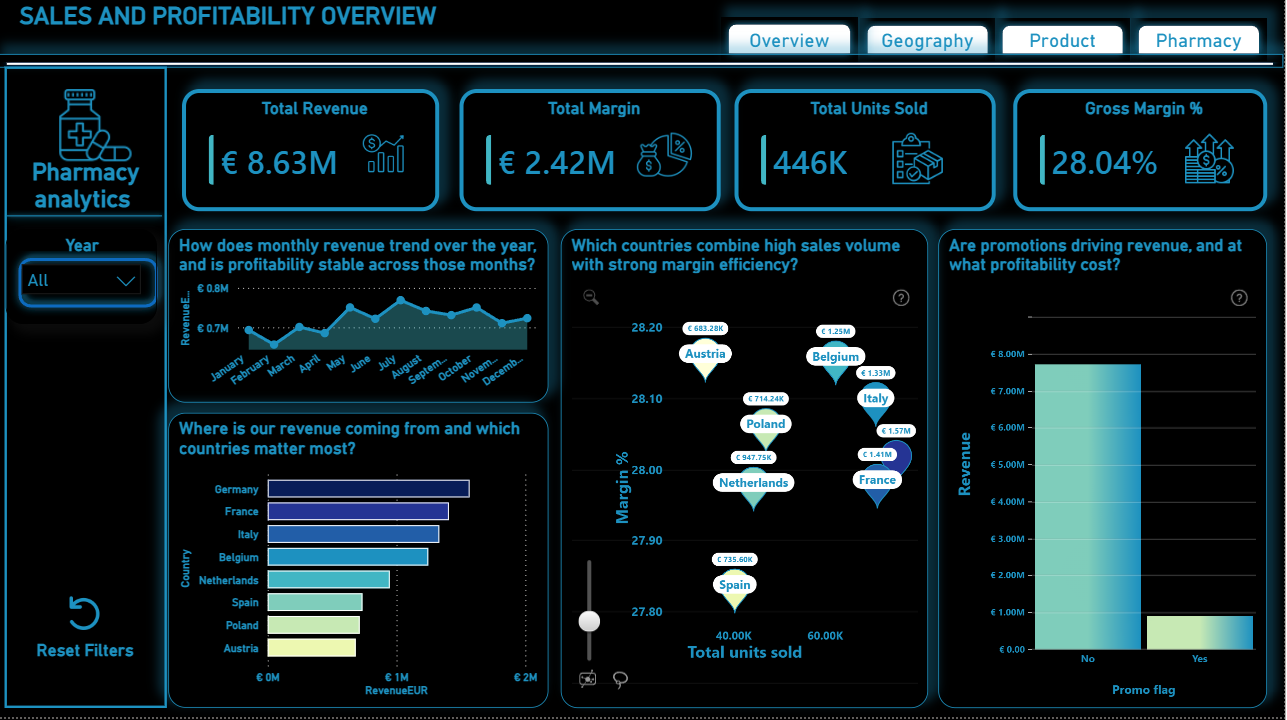


---

##### Page 2 — Geographic Drilldown (Country → Region → Pharmacy)

**KPIS**

**1. Active Pharmacies**

Question it answers:

How many stores are operating in this selected geography?

A country with 2M revenue is very different from 2M from 50 stores.


In [ ]:
def active_pharmacies_sales_based(df, year):
    return (
        df[df["Year"] == year]["PharmacyID"]
        .nunique()
    )

In [29]:
def active_pharmacies_geo(df, year, country=None):
    temp = df[df["Year"] == year]

    if country:
        temp = temp[temp["Country"] == country]
    return temp["PharmacyID"].nunique()

In [30]:
active_2024 = active_pharmacies_sales_based(sales_enriched_final, 2024)
active_2025 = active_pharmacies_sales_based(sales_enriched_final, 2025)
print(f"Active pharmacies in 2024: {active_2024}")
print(f"Active pharmacies in 2025: {active_2025}")

Active pharmacies in 2024: 113
Active pharmacies in 2025: 120


In [31]:
sample_ids = sales_enriched_final["PharmacyID"].dropna().unique()[:5]
print(sample_ids)

['PH0002' 'PH0004' 'PH0007' 'PH0009' 'PH0010']


In [32]:
sales_enriched_final[
    (sales_enriched_final["Year"] == 2024) &
    (sales_enriched_final["PharmacyID"] == sample_ids[0])
].head()

,SalesID,DateKey,PharmacyID,ProductID,UnitsSold,RevenueEUR,CostEUR,MarginEUR,PromoFlag,Date,...,Category,Brand,IsGeneric,PackSize,ListPriceEUR,StandardCostEUR,LaunchDate,IsDiscontinued,DiscontinuedDate,year
0,S0000001,20240101,PH0002,PR0099,5,128.08,87.55,40.53,No,2024-01-01,...,Personal Care,HairEssence,No,150 ml,24.63,17.25,2018-12-06,No,NaT,2024
93,S0000094,20240102,PH0002,PR0170,7,178.94,117.98,60.96,No,2024-01-02,...,Personal Care,SkinGuard,No,400 ml,24.58,16.59,2015-01-15,No,NaT,2024
173,S0000174,20240103,PH0002,PR0061,7,20.97,14.34,6.63,No,2024-01-03,...,Personal Care,SmileBright,No,250 ml,2.88,2.14,2021-02-08,No,NaT,2024
435,S0000436,20240106,PH0002,PR0065,9,82.37,57.66,24.71,No,2024-01-06,...,Personal Care,CleanWave,No,100 ml,8.80,6.32,2016-02-03,No,NaT,2024
436,S0000437,20240106,PH0002,PR0096,13,96.67,64.45,32.22,No,2024-01-06,...,OTC,ColdAway,No,100 ml,7.15,5.03,2024-08-25,Yes,2025-09-10,2024


In [33]:
for y in sorted(sales_enriched_final["Year"].unique()):
    print(y, sales_enriched_final[sales_enriched_final["Year"]==y]["PharmacyID"].nunique())

2024 113
2025 120


In [34]:
ph_2024 = set(sales_enriched_final[sales_enriched_final["Year"]==2024]["PharmacyID"].unique())
ph_2025 = set(sales_enriched_final[sales_enriched_final["Year"]==2025]["PharmacyID"].unique())

missing = ph_2024 - ph_2025
print("Pharmacies active in 2024 but not 2025:", len(missing))
list(missing)[:10]

Pharmacies active in 2024 but not 2025: 0


[]

In [35]:
total_pharmacies = pharmacy_df["PharmacyID"].nunique()
active_2024 = sales_enriched_final[sales_enriched_final["Year"]==2024]["PharmacyID"].nunique()

print("Total pharmacies in master:", total_pharmacies)
print("Active pharmacies in 2024:", active_2024)

Total pharmacies in master: 120
Active pharmacies in 2024: 113


In [37]:
sales_enriched_final["PharmacyID"].nunique()


120

In [38]:
sales_enriched_final["PharmacyID"].str.strip().nunique()

120

In [39]:
ph_2024 = set(sales_enriched_final[sales_enriched_final["year"]==2024]["PharmacyID"].unique())
ph_2025 = set(sales_enriched_final[sales_enriched_final["year"]==2025]["PharmacyID"].unique())

new_in_2025 = ph_2025 - ph_2024

print("New pharmacies appearing in 2025:", len(new_in_2025))
print(sorted(list(new_in_2025))[:15])

New pharmacies appearing in 2025: 7
['PH0001', 'PH0003', 'PH0011', 'PH0040', 'PH0084', 'PH0102', 'PH0115']


In [40]:
sales_enriched_final[
    sales_enriched_final["PharmacyID"].isin(new_in_2025)
].groupby("PharmacyID")["Date"].min()

PharmacyID
PH0001   2025-04-05
PH0003   2025-04-20
PH0011   2025-04-06
PH0040   2025-03-28
PH0084   2025-07-03
PH0102   2025-04-21
PH0115   2025-12-13
Name: Date, dtype: datetime64[ns]

In [45]:
def active_pharmacies_open_based(df, year):
    period_end = pd.Timestamp(f"{year}-12-31")
    df['OpenDate'] = pd.to_datetime(df['OpenDate'])
    active_mask = df["OpenDate"] <= period_end

    return df.loc[active_mask, "PharmacyID"].nunique()

In [46]:
active_2024 = active_pharmacies_open_based(sales_enriched_final, 2024)
print("Active pharmacies (open by 2024-12-31):", active_2024)
active_2025 = active_pharmacies_open_based(sales_enriched_final, 2025)
print("Active pharmacies (open by 2025-12-31):", active_2025)

Active pharmacies (open by 2024-12-31): 113
Active pharmacies (open by 2025-12-31): 120


**2.Avg Revenue Per Pharmacy**

In [49]:
# calculate avg revenue per pharmacy
def total_revenue(df, year):
    return df[df["Year"] == year]["RevenueEUR"].sum()

In [50]:
def avg_revenue_per_pharmacy(df, pharmacy_df, year):
    revenue = total_revenue(df, year)
    active_count = active_pharmacies_open_based(pharmacy_df, year)

    return revenue / active_count if active_count > 0 else 0

In [53]:
avg_2024 = avg_revenue_per_pharmacy(sales_enriched_final, pharmacy_df, 2024)
avg_2025 = avg_revenue_per_pharmacy(sales_enriched_final, pharmacy_df, 2025)

print("Avg Revenue per Pharmacy (2024):", round(avg_2024, 2))
print("Avg Revenue per Pharmacy (2025):", round(avg_2025, 2))


Avg Revenue per Pharmacy (2024): 37375.35
Avg Revenue per Pharmacy (2025): 36754.69


In [54]:
total_rev_2024 = total_revenue(sales_enriched_final, 2024)
active_2024 = active_pharmacies_open_based(pharmacy_df, 2024)

print("Total Revenue 2024:", total_rev_2024)
print("Active Pharmacies 2024:", active_2024)
print("Revenue / Pharmacies:", total_rev_2024 / active_2024)

Total Revenue 2024: 4223414.13
Active Pharmacies 2024: 113
Revenue / Pharmacies: 37375.34628318584


In [56]:
total_rev_all = sales_enriched_final["RevenueEUR"].sum()
print("Total Revenue All Pharmacies:", total_rev_all)

Total Revenue All Pharmacies: 8633977.31


In [57]:
latest_year = sales_enriched_final["year"].max()
active_latest = active_pharmacies_open_based(pharmacy_df, latest_year)

print("Active Pharmacies (latest year):", active_latest)

Active Pharmacies (latest year): 120


In [58]:
overall_avg_rev = total_rev_all / active_latest
print("Overall Avg Revenue per Pharmacy:", round(overall_avg_rev, 2))

Overall Avg Revenue per Pharmacy: 71949.81


**Pharmacy Performance Spread(Inequality/ Risk KPI)**

Is performance consistent, or are we relying on a few superstar stores?

if top 10% store generate 60% revenue -> high dependency risk. 

so far all the three kpis answer:

How many pharmacies are there?

How productive they are on average (avg revenue/store)

how profitable the geography is (margin%)

but none of them answer:

Is the business healthly across the network, or is it being carried by a few stores?

the core question is: are we diversified or fragile?

Business meaning:

What % of total revenue comes from the top 10% highest revenue pharmacies?


In [ ]:
# Revenue per Pharmacy

rev_by_store = (
    sales_enriched_final
    .groupby("PharmacyID")["RevenueEUR"]
    .sum()
    .sort_values(ascending=False)
)

rev_by_store.head()
# this gives a rank to each store based on revenue generated now the stores are ordered from best -> worst.

PharmacyID
PH0095    162320.29
PH0023    159495.01
PH0058    158935.66
PH0078    151533.96
PH0010    147924.27
Name: RevenueEUR, dtype: float64

In [60]:
# total revenue
total_revenue = rev_by_store.sum()
print("Total Revenue (All Stores):", total_revenue)

Total Revenue (All Stores): 8633977.31


In [ ]:
# Identify Top 10% Store
# the stores that are in the highest-performing decile by revenue.
import numpy as np
n_stores = len(rev_by_store) # if you have 120 stores 10% = 12 stores 
top_n = int(np.ceil(n_stores * 0.10)) # this is just [0.10 x n_stores]
# so for example: 10% of 120 = 12
# why use ceil?
# we can't have fractional stores 
# hence floor -> 11 stores(slightly under 10%)
# ceil -> 12 stores(slightly over 10%)
# why choose ceil? 
# Exec prefer including at least the full top decile rather than excluding a top performer due to rounding.
print("Total Stores:", n_stores)
print("Top 10% Stores:", top_n)

Total Stores: 120
Top 10% Stores: 12


In [63]:
top_revenue = rev_by_store.head(top_n).sum()
print("Revenue from Top Stores:", top_revenue)

Revenue from Top Stores: 1733900.9500000002


In [64]:
# Revenue Share 
top_store_share = top_revenue/ total_revenue
print("Revenue Share by Top Stores:", round(top_store_share * 100, 2), "%")

Revenue Share by Top Stores: 20.08 %


In [65]:
rev_by_store.head(top_n)

PharmacyID
PH0095    162320.29
PH0023    159495.01
PH0058    158935.66
PH0078    151533.96
PH0010    147924.27
PH0073    143722.53
PH0055    137422.29
PH0109    135770.62
PH0074    135215.32
PH0085    134961.07
PH0106    134838.87
PH0018    131761.06
Name: RevenueEUR, dtype: float64

In [66]:
cumulative_share = rev_by_store.cumsum() / total_revenue
cumulative_share.head(15)

PharmacyID
PH0095    0.018800
PH0023    0.037273
PH0058    0.055681
PH0078    0.073232
PH0010    0.090365
PH0073    0.107011
PH0055    0.122928
PH0109    0.138653
PH0074    0.154314
PH0085    0.169945
PH0106    0.185562
PH0018    0.200823
PH0056    0.216021
PH0104    0.230833
PH0053    0.245227
Name: RevenueEUR, dtype: float64

In [67]:
def top_store_share_by_country(df, top_pct=0.10):
    results = {}

    for country, group in df.groupby("Country"):

        rev_by_store = (
            group.groupby("PharmacyID")["RevenueEUR"]
            .sum()
            .sort_values(ascending=False)
        )

        n_stores = len(rev_by_store)
        if n_stores <= 1:
            continue

        top_n = int(np.ceil(n_stores * top_pct))

        total_rev = rev_by_store.sum()
        top_rev = rev_by_store.head(top_n).sum()

        results[country] = round((top_rev / total_rev) * 100, 2)

    return pd.Series(results).sort_values(ascending=False)

In [68]:
top_share_country = top_store_share_by_country(sales_enriched_final)
print(top_share_country)

Netherlands    33.60
Spain          32.68
Poland         28.97
Germany        27.72
Belgium        24.02
Italy          19.98
Austria        19.79
France         17.85
dtype: float64


#### Page 2 — Geographic Performance Breakdown

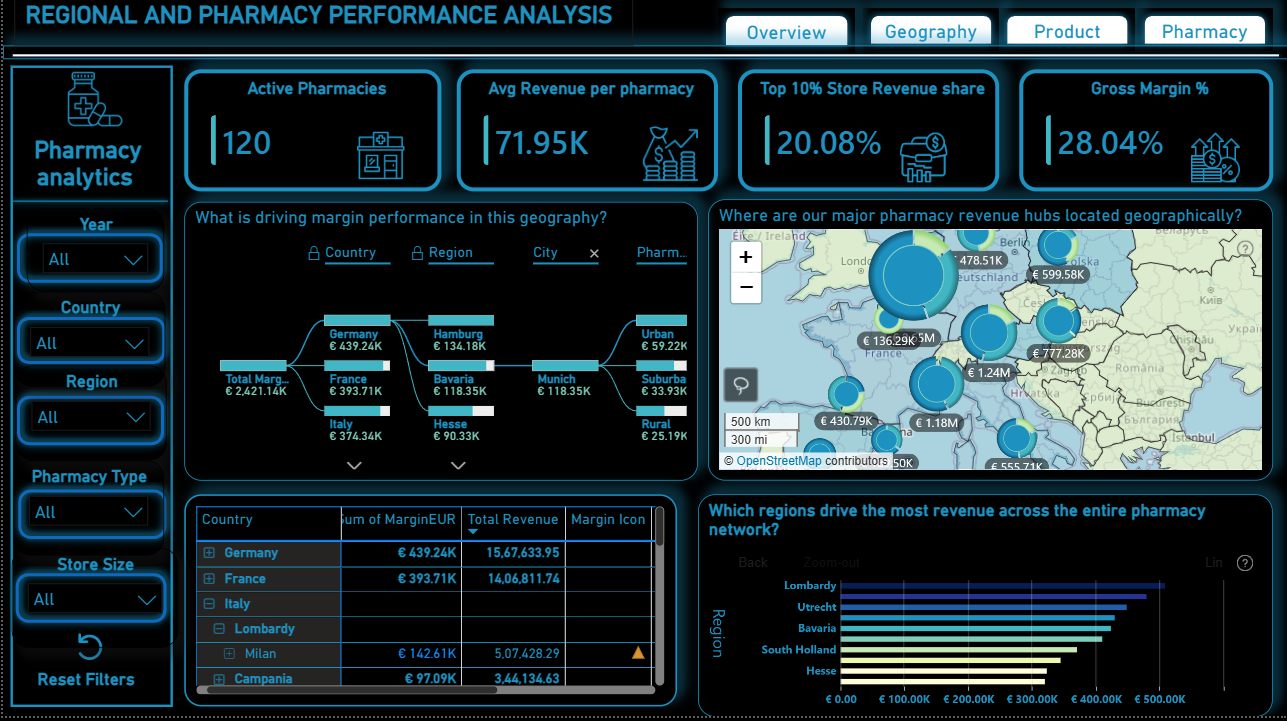

##### Purpose

Page 2 provides a deeper geographic performance breakdown beyond the executive overview. It enables stakeholders to explore which regions matter most within each country, which pharmacies outperform or underperform, and whether performance is consistent or concentrated in a few stores.

---

##### Key Business Questions Answered

- How does performance vary from Country → Region → Pharmacy?
- Are stores productive or just numerous in a geography?
- Which regions are the strongest revenue contributors?
- Are we dependent on a small set of superstar pharmacies?

---

##### KPI Diagnostics (Geography-Specific)

Unlike Page 1 global KPIs, Page 2 focuses on geographic operational insights.

##### 1. Active Pharmacies (Footprint)
**Question:** How many pharmacies are operating in the selected geography and year?  
**Logic:** Count stores opened on or before the selected period.

##### 2. Avg Revenue per Pharmacy (Store Productivity)
**Question:** Are stores efficient, or is revenue driven by store count?  
**Formula:**  
$$AvgRevenue = \frac{TotalRevenue}{ActivePharmacies}$$

##### 3. Top 10% Store Revenue Share (Concentration Risk)
**Question:** Are we relying heavily on a few high-performing pharmacies?
- High share → dependency risk
- Low share → diversified performance

##### 4. Gross Margin % (Profit Benchmark)
**Question:** Is profitability in this geography above or below the company baseline?

---

##### Core Visuals

##### 1. Drilldown Matrix (Country → Region → Pharmacy)
Acts as the main exploration tool. Displays Revenue, Margin, and Margin performance indicator. Stakeholders can drill into underperforming stores directly.

##### 2. Decomposition Tree — Margin Drivers
**Question:** What is driving margin performance in this geography?  
Breaks margin contribution across: Country → Region → City → PharmacyType

##### 3. Region Contribution Ranking
**Question:** Which regions drive the most revenue across the network?  
Ranks top regions globally or within selected countries.

##### 4. Pharmacy Revenue Hub Map
**Question:** Where are our major pharmacy revenue hubs located?  
Provides geographic footprint validation through:
- Bubble size = revenue scale
- Spatial clustering = regional concentration

---

##### Filters / Slicers

Page 2 supports structured drilldown using: Year, Country, Region, Pharmacy Type, and Store Size Band.

---

##### Outcome

Page 2 transforms high-level reporting into actionable geographic diagnostics by identifying top-performing regions, inefficient store clusters, margin drivers, and revenue concentration risk.

##### Page 3 - Product and Profitability Drivers

**KPIS**

**1. Active Products**

Business meaning:

How many products were actually available for sale during the selected period?

Not:

how many products exist in the master table 

Not:

how many products appear somewhere in sales history



In [75]:
product_df["LaunchDate"] = pd.to_datetime(product_df["LaunchDate"])
product_df["DiscontinuedDate"] = pd.to_datetime(product_df["DiscontinuedDate"])


period_end = pd.Timestamp('2024-12-31')

active_products_2024 = product_df[
    (product_df["LaunchDate"] <= period_end) &
    (
        product_df["DiscontinuedDate"].isna() | 
        (product_df["DiscontinuedDate"] > period_end)
    )
]["ProductID"].nunique()

print("Active Products in 2024:", active_products_2024)


Active Products in 2024: 180


In [74]:
period_end = pd.Timestamp("2025-12-31")

active_products_2025 = product_df[
    (product_df["LaunchDate"] <= period_end) &
    (
        product_df["DiscontinuedDate"].isna() |
        (product_df["DiscontinuedDate"] > period_end)
    )
]["ProductID"].nunique()

print("Active Products in 2025:", active_products_2025)

Active Products in 2025: 185


**2. Product Mix Margin %**

Business meaning:

Is the selected product mix profitable or are we selling low-margin volume?

this kpi changes meaningfully when filtered by:

category

brand 

Country

Generic vs Branded

Interpretation:

Higher % -> profitable category/brand mix

Lower % -> margin leakage or price pressure

Stable % over time -> healthy product economics

Filter Behaviour

No filters

-> Global company margin%

Category selected

-> Margin % for that category only

Brand selected 

-> Brand profitability benchmark



**Top Product Driver**

Business Question:

which product generates the highest revenue in the current selection of products?

Examples:

1. Germany -> Top product is X

2. OTC -> Top product is Y

3. Store PHOO95 -> Top product is Z



In [9]:
sales_enriched_final["LaunchDate"] = pd.to_datetime(sales_enriched_final["LaunchDate"])
sales_enriched_final["DiscontinuedDate"] = pd.to_datetime(sales_enriched_final["DiscontinuedDate"])

sales_enriched_final["Date"] = pd.to_datetime(sales_enriched_final["Date"])

In [10]:
period_end = sales_enriched_final["Date"].max()
print("Global period end:", period_end)

Global period end: 2025-12-31 00:00:00


In [18]:
product_rev = (
    sales_enriched_final
    .groupby(["ProductID", "ProductName"], as_index=False)
    .agg(
        RevenueEUR=("RevenueEUR", "sum"),
        LaunchDate=("LaunchDate", "min"),
        DiscontinuedDate=("DiscontinuedDate", "min")
    )
)

print(product_rev.head())
print(product_rev.columns)

  ProductID                            ProductName  RevenueEUR LaunchDate  \
0    PR0001  CareEquip Glucose Test Strips Compact     6453.64 2018-04-09   
1    PR0002              Medica Nasal Spray 100 mg    21839.11 2015-08-21   
2    PR0003              VitaCare Vitamin C 100 mg    41809.99 2022-11-22   
3    PR0004               DermaSoft Shampoo Repair    31711.85 2018-01-10   
4    PR0005        CleanWave Moisturizer Sensitive    36248.47 2025-08-11   

  DiscontinuedDate  
0              NaT  
1              NaT  
2              NaT  
3              NaT  
4              NaT  
Index(['ProductID', 'ProductName', 'RevenueEUR', 'LaunchDate',
       'DiscontinuedDate'],
      dtype='object')


In [19]:
period_end = sales_enriched_final["Date"].max()

active_products = product_rev[
    (product_rev["LaunchDate"] <= period_end) &
    (
        product_rev["DiscontinuedDate"].isna() |
        (product_rev["DiscontinuedDate"] > period_end)
    )
]

In [20]:
top_product = active_products.sort_values("RevenueEUR", ascending=False).head(1)

print("✅ Global Top Product Driver (Active Only):")
print(top_product[["ProductID", "ProductName", "RevenueEUR"]])

✅ Global Top Product Driver (Active Only):
    ProductID              ProductName  RevenueEUR
149    PR0150  AntiBioX Inhaler 200 mg   119329.81


**KPI 4 - Low Margin Volume Share (Volume Trap Exposure)**

Business Question:

How much of our total units sold comes from low-margin products?

this tells stakeholders:

1. Are we moving a lot of volume without earning enough profit?

2. Is the product mix healthy or margin-leaking?

**Why is this important?**

A category can look strong because it sells a lot of volume but if most of the volumne comes from low-margin items then:

1. Profitability suffers

2. promotions may be destorying margin

3. the business is running on weak economics

$$LowMarginVolumeShare = \frac{\text{Units sold from low-margin products}}{\text{Total units sold}}$$

We need two things:

1. A margin threshold of 20%

2. Filter products below the threshold

3. Compute their unit share 



In [ ]:
# first calculate margin % for each product

# Aggregate at product level
product_summary = (
    sales_enriched_final
    .groupby("ProductID", as_index=False)
    .agg(
        TotalUnits=("UnitsSold", "sum"),
        TotalRevenue=("RevenueEUR", "sum"),
        TotalMargin=("MarginEUR", "sum"),
    )
)
# product-level margin %%!
product_summary["MarginPct"] = (
product_summary["TotalMargin"] / product_summary["TotalRevenue"]
)
product_summary.head()

# Margin % must be evaluated per product and not globally


,ProductID,TotalUnits,TotalRevenue,TotalMargin,MarginPct
0,PR0001,660,6453.64,1479.71,0.229283
1,PR0002,3181,21839.11,5719.68,0.261901
2,PR0003,3190,41809.99,10626.05,0.254151
3,PR0004,2152,31711.85,12217.60,0.385269
4,PR0005,2612,36248.47,10719.38,0.295720


In [23]:
# Define Low-Margin Threshold
# Low margin product = Margin % < 20%
threshold = 0.20

In [24]:
# Identify Low-Margin Products
low_margin_products = product_summary
[
    product_summary["MarginPct"] < threshold
]
print("Low margin products:", len(low_margin_products))

Low margin products: 220


In [41]:
# Compute Units Sold from Low-Margin Products
low_margin_products_units = low_margin_products["TotalUnits"].sum()
print("Low margin products units:", low_margin_products_units)

Low margin products units: 16297


In [42]:
# Compute Totla Units Sold 
total_units_sold = product_summary["TotalUnits"].sum()
print("Total units sold:", total_units_sold)

Total units sold: 445793


In [27]:
product_summary["MarginPct"].describe()

count    220.000000
mean       0.288759
std        0.053341
min        0.174788
25%        0.246127
50%        0.295216
75%        0.329977
max        0.388285
Name: MarginPct, dtype: float64

In [28]:
product_summary.sort_values("MarginPct", ascending=False).head(10)

,ProductID,TotalUnits,TotalRevenue,TotalMargin,MarginPct
152,PR0153,2092,29797.40,11569.87,0.388285
3,PR0004,2152,31711.85,12217.60,0.385269
166,PR0167,1574,13665.73,5242.33,0.383611
146,PR0147,2358,39147.08,14964.31,0.382259
211,PR0212,2283,5196.86,1984.07,0.381782
204,PR0205,2373,52851.84,20018.12,0.378759
113,PR0114,2361,58768.35,22236.55,0.378376
109,PR0110,1105,22993.38,8698.75,0.378315
89,PR0090,2498,34140.39,12911.69,0.378194
139,PR0140,2445,56692.89,21384.65,0.377202


In [29]:
sales_enriched_final[["RevenueEUR", "CostEUR", "MarginEUR"]].describe()

,RevenueEUR,CostEUR,MarginEUR
count,62139.000000,62139.000000,62139.000000
mean,138.946190,99.982881,38.963309
std,124.574712,93.611370,33.972445
min,1.610000,1.100000,0.440000
25%,55.250000,39.330000,15.140000
50%,102.750000,72.220000,28.990000
75%,181.350000,128.680000,51.990000
max,1036.280000,834.420000,295.310000


In [30]:
sales_enriched_final[["RevenueEUR", "CostEUR", "MarginEUR"]].describe()

,RevenueEUR,CostEUR,MarginEUR
count,62139.000000,62139.000000,62139.000000
mean,138.946190,99.982881,38.963309
std,124.574712,93.611370,33.972445
min,1.610000,1.100000,0.440000
25%,55.250000,39.330000,15.140000
50%,102.750000,72.220000,28.990000
75%,181.350000,128.680000,51.990000
max,1036.280000,834.420000,295.310000


In [31]:
check = sales_enriched_final.copy()
check["ComputedMargin"] = check["RevenueEUR"] - check["CostEUR"]

print((check["ComputedMargin"] - check["MarginEUR"]).abs().mean())

6.409568602835421e-15


In [32]:
(product_summary["MarginPct"] < 0.20).sum()

np.int64(12)

In [39]:
low_margin_products = product_summary[product_summary["MarginPct"] < 0.20]

print("Low margin product count:", len(low_margin_products))
print(low_margin_products.sort_values("MarginPct").head())

Low margin product count: 12
    ProductID  TotalUnits  TotalRevenue  TotalMargin  MarginPct
79     PR0080        1349      80132.47     14006.22   0.174788
59     PR0060        1359      94903.50     16887.89   0.177948
208    PR0209        1541      60343.48     10987.74   0.182087
118    PR0119        1331      37405.60      6832.85   0.182669
184    PR0185        1606      20374.86      3744.83   0.183797


In [40]:
low_margin_units = low_margin_products["TotalUnits"].sum()
total_units = product_summary["TotalUnits"].sum()

print("Low margin units:", low_margin_units)
print("Total units:", total_units)
print("Share:", low_margin_units / total_units)

Low margin units: 16297
Total units: 445793
Share: 0.03655732593378541


In [ ]:
cutoff = product_summary["MarginPct"].quantile(0.20)

low_margin_products = product_summary[
    product_summary["MarginPct"] <= cutoff
]

low_margin_units = low_margin_products["TotalUnits"].sum()
total_units = product_summary["TotalUnits"].sum()

print("Cutoff margin:", cutoff)
print("Low-margin volume share:", low_margin_units / total_units)

# We Use Percentile-Based Volume trap share because bottom 20% of margin products is more defensible.

Cutoff margin: 0.23617013650577087
Low-margin volume share: 0.11907768852359728


##### 📘 Page 3 — Product Performance & Profitability Analysis 
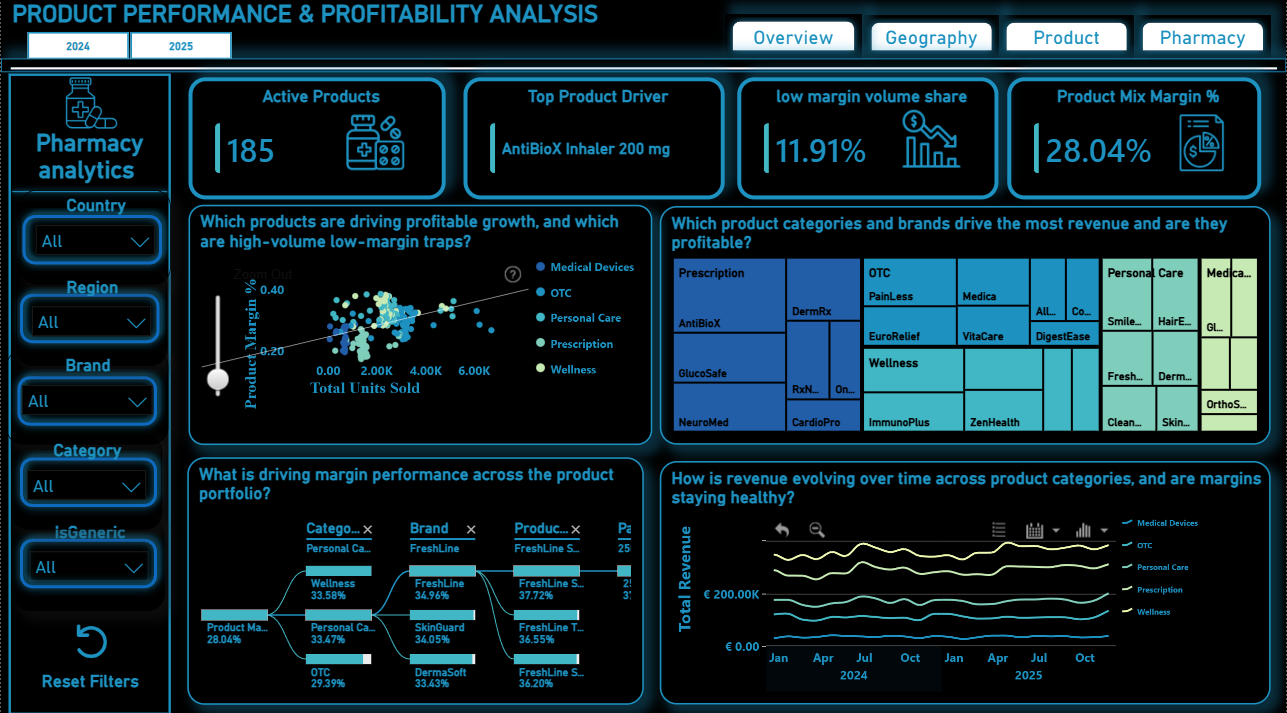

##### Objective

This notebook supports the **Product Performance & Profitability Analysis** page of the Power BI report.

The goal of this analysis is to:
- Evaluate product-level revenue and margin performance.
- Identify high-volume low-margin risks.
- Detect revenue concentration across categories and brands.
- Assess time-based revenue patterns.
- Support product strategy and portfolio optimization decisions.

---

##### 1️⃣ Active Products

##### Logic

A product is considered active in a given period if:
- `LaunchDate <= PeriodEnd`
- AND (`DiscontinuedDate` is null OR `DiscontinuedDate > PeriodEnd`)

##### Why This Matters

This ensures:
- Discontinued products are not included in performance evaluation.
- Historical accuracy in portfolio size.
- KPI alignment with selected year filters (2024 / 2025).

| Metric Computed |
|---|
| Active Products = Count of unique `ProductID` satisfying active logic |

---

##### 2️⃣ Top Product Driver

##### Logic
1. Filter products to active products.
2. Aggregate total revenue per `ProductID`.
3. Identify product with maximum revenue in current filter context.

##### DAX Conceptual Representation
```dax
Top Product Driver =
TOPN(
    1,
    SUMMARIZE(ActiveProducts, ProductID, Revenue),
    Revenue,
    DESC
)
```

##### Purpose
- Identifies revenue concentration.
- Supports SKU-level performance review.
- Changes dynamically with geography and category filters.

---

##### 3️⃣ Low-Margin Volume Share

#### Step 1 — Compute Product-Level Metrics

Aggregate by Product:
- `TotalUnits`
- `TotalRevenue`
- `TotalMargin`
- `MarginPct = TotalMargin / TotalRevenue`

#### Step 2 — Define Low-Margin Threshold

Approach used:
- Compute margin percentile cutoff (e.g., 25th percentile).
- Flag products below this threshold as low-margin.
```python
Cutoff = MarginPct.quantile(0.25)
LowMarginFlag = MarginPct < Cutoff
```

##### Step 3 — Compute Volume Share
```python
LowMarginUnits = Sum(TotalUnits where LowMarginFlag = True)
TotalUnits = Sum(TotalUnits)

LowMarginVolumeShare = LowMarginUnits / TotalUnits
```

##### Purpose

This metric detects **structural profitability risk** by identifying how much volume depends on low-margin products.

---

##### 4️⃣ Product Mix Margin %

##### Logic
```
Product Mix Margin % = Total Margin / Total Revenue
```

##### Interpretation
- Represents overall portfolio profitability.
- Changes dynamically based on filters.
- Sensitive to product mix shifts.

---

##### 5️⃣ Product Profitability Quadrant (Scatter)

##### Data Preparation

Aggregate at Product level:
- `TotalUnits`
- `MarginPct`
- `Revenue`

##### Axes
- **X-axis:** TotalUnits
- **Y-axis:** MarginPct

##### Interpretation

| Volume | Margin | Interpretation |
|---|---|---|
| High | High | Strategic Growth Drivers |
| High | Low | Volume Traps |
| Low | High | Niche Profit Drivers |
| Low | Low | Underperformers |

##### Analytical Value
- Detects pricing inefficiencies.
- Identifies scale candidates.
- Highlights margin dilution risks.

---

##### 6️⃣ Revenue Distribution Treemap

##### Aggregation Logic

Group by:
- Category
- Brand

Compute:
- Total Revenue
- Margin %

##### Purpose
- Identify revenue concentration.
- Detect dominant product segments.
- Support portfolio balancing decisions.

---

##### 7️⃣ Margin Decomposition Tree

##### Breakdown Structure
```
Total Margin
    → Category
        → Brand
            → Product
```

##### Analytical Purpose
- Explain what drives margin performance.
- Detect high or low profitability segments.
- Enable structured root-cause analysis.

---

##### 8️⃣ Category Revenue Trend (TimeSeries)

###### Data Aggregation

Group by:
- `YearMonth`
- `Category`

Compute:
- Total Revenue
- Margin %
- Units Sold
- Promo Revenue Share %

##### Purpose
- Identify seasonality.
- Detect revenue momentum.
- Evaluate margin stability over time.
- Compare 2024 vs 2025 performance.

---

##### Filters Applied on Page 3

- Year (2024 / 2025)
- Country
- Region
- Brand
- Category
- IsGeneric

These filters dynamically adjust:
- All KPIs
- Product-level aggregates
- Time-based analysis
- Margin calculations

---

##### Final Analytical Outcome

This page ensures that:
- Revenue growth is evaluated alongside profitability.
- High-volume products are not automatically assumed to be strategic.
- Product portfolio health is measured structurally.
- Margin dilution risks are quantified.
- Time trends are incorporated into product evaluation.

#### Page 4 — Business Levers and Strategic Actions 



**KPIS**

**1. Promotion Margin Impact**

$$\text{Promotion Margin Impact} = \text{Promo Margin\%} - \text{Non-Promo Margin\%}$$

Where:

1. Promo Margin% = MarginEUR / RevenueEUR (for Promo transactions)

2. Non-Promo Margin% = MarginEUR / RevenueEUR (for Non-Promo transactions)

**What this KPI Actually Measures**

it measures:

The difference in profitability efficiency between promotional and non-promotional sales.

it does not measure:

- Total profit generated
- Incremental profit 
- Return on promotion spend
- Long-term impact

it purely measures profitability per euro of revenue.

**Theoretical Interpretation**

**If Promotion Margin Impact is Positive **

Promo Margin % > Non-Promo Margin %

This means:

- Promoted transactions generate higher margin efficiency.
- Discounting (if any) is not harming margin proportionally.
- Possibly:
- Promotions are selective.
- They are applied to higher-margin products.
- Volume increase offsets discount. 

Theoretical Interpretation:

``Promotions improve margin quality per unit of revenue.``

**If Promotion Margin Impact is Negative **

Promo Margin % < Non-Promo Margin %

This means:

- Promoted transactions generate lower margin efficiency.
- Discounting is harming margin proportionally.
- Possibly:
- Promotions are applied to lower-margin products.
- Volume decrease cannot offset discount.

**Theoretical Interpretation**

``Promotions reduce profitability effciency.``



In [10]:
sales_enriched_final["PromoFlag"].unique()

array(['No', 'Yes'], dtype=object)

In [12]:
promo_summary = (
    sales_enriched_final
    .groupby("PromoFlag")[["RevenueEUR", "MarginEUR"]]
    .sum()
)
promo_summary


,RevenueEUR,MarginEUR
PromoFlag,,
No,7722676.25,2239573.20
Yes,911301.06,181567.87


In [13]:
promo_summary["MarginPct"] = (
    promo_summary["MarginEUR"] / promo_summary["RevenueEUR"] 
)
promo_summary

,RevenueEUR,MarginEUR,MarginPct
PromoFlag,,,
No,7722676.25,2239573.20,0.29000
Yes,911301.06,181567.87,0.19924


In [14]:
promo_margin_pct = promo_summary.loc["Yes", "MarginPct"]
non_promo_margin_pct = promo_summary.loc["No", "MarginPct"]
promotion_margin_impact = promo_margin_pct - non_promo_margin_pct
print(f"Promo Margin %: {promo_margin_pct:.2f}%")
print(f"Non-Promo Margin %: {non_promo_margin_pct:.2f}%")
print(f"Promotion Margin Impact: {promotion_margin_impact:.2f}%")

Promo Margin %: 0.20%
Non-Promo Margin %: 0.29%
Promotion Margin Impact: -0.09%


In [15]:
category_promo = (
    sales_enriched_final
    .groupby(["Category", "PromoFlag"])[["RevenueEUR", "MarginEUR"]]
    .sum()
    .reset_index()
)

category_promo["MarginPct"] = (
    category_promo["MarginEUR"] / category_promo["RevenueEUR"]
)

category_promo

,Category,PromoFlag,RevenueEUR,MarginEUR,MarginPct
0,Medical Devices,No,779619.95,202025.43,0.259133
1,Medical Devices,Yes,92952.02,15791.04,0.169884
2,OTC,No,1610572.58,487899.45,0.302935
3,OTC,Yes,186756.97,40266.58,0.215610
4,Personal Care,No,1314042.81,450445.02,0.342793
5,Personal Care,Yes,140560.34,36430.16,0.259178
6,Prescription,No,2484255.43,570116.78,0.229492
7,Prescription,Yes,312760.33,43049.61,0.137644
8,Wellness,No,1534185.48,529086.52,0.344865
9,Wellness,Yes,178271.40,46030.48,0.258205


In [17]:
category_pivot = category_promo.pivot(
    index="Category",
    columns="PromoFlag",
    values="MarginPct"
)

category_pivot["PromotionMarginImpact"] = (
    category_pivot["Yes"] - category_pivot["No"]
)

category_pivot

PromoFlag,No,Yes,PromotionMarginImpact
Category,,,
Medical Devices,0.259133,0.169884,-0.089249
OTC,0.302935,0.215610,-0.087326
Personal Care,0.342793,0.259178,-0.083615
Prescription,0.229492,0.137644,-0.091848
Wellness,0.344865,0.258205,-0.086660


#### 🔍 What Your Numbers Actually Say

##### Global Overview

| Metric | Value |
|---|---|
| Non-Promo Margin | ≈ 29% |
| Promo Margin | ≈ 20% |
| Margin Impact | ≈ **–9 pp** |

---

##### Category-Level Breakdown

| Category | Non-Promo | Promo | Impact |
|---|---|---|---|
| Medical Devices | 25.9% | 16.9% | –8.9 pp |
| OTC | 30.3% | 21.6% | –8.7 pp |
| Personal Care | 34.3% | 25.9% | –8.4 pp |
| Prescription | 22.9% | 13.8% | –9.2 pp |
| Wellness | 34.5% | 25.8% | –8.7 pp |

> This is **structurally consistent** across categories — and that tells us something very important.

---

##### 🧠 Structural Interpretation

> **This is not a category problem.**
> **This is a pricing design problem.**

Promotions are compressing margin in **every category almost equally (~8–9 pp)**.

That suggests:
- A **flat discount structure**, or
- **Systematic % discounting**, or
- A margin model where **discount directly erodes contribution**

This is not selective promotion. This is **mechanical discounting**.

---

##### 🚨 Strategic Implication (But Not Final Yet)

At face value — **promotions are materially reducing profitability efficiency.**

But we **cannot conclude "reduce promotions" yet**, because we have not checked:
- Promo revenue share
- Promo unit share
- Absolute margin €
- Volume lift

---

##### 🧠 Critical Thinking Layer

If margin drops by **9 percentage points**:
```
From ~29% → ~20%
= 31% relative reduction in profitability efficiency
```

That is **significant.**

The only justification for that would be:
- Massive incremental **volume lift**
- Strategic **customer acquisition** goal
- **Inventory clearance** objective
- **Competitive defense** necessity

> Otherwise — it is **economically destructive.**

In [18]:
# Promo Revenue Share % 
# What % of total revenue comes from promo?
total_revenue = sales_enriched_final["RevenueEUR"].sum()

promo_revenue = (
    sales_enriched_final
    .loc[sales_enriched_final["PromoFlag"] == "Yes", "RevenueEUR"]
    .sum()
)

promo_revenue_share = promo_revenue / total_revenue

print("Total Revenue:", total_revenue)
print("Promo Revenue:", promo_revenue)
print("Promo Revenue Share %:", promo_revenue_share)

Total Revenue: 8633977.31
Promo Revenue: 911301.06
Promo Revenue Share %: 0.10554823429342554


In [20]:
# Promo Margin vs Non Promo Margin
# How much absolute profit comes from each segment?
total_margin = sales_enriched_final["MarginEUR"].sum()

promo_margin = (
    sales_enriched_final
    .loc[sales_enriched_final["PromoFlag"] == "Yes", "MarginEUR"]
    .sum()
)

nonpromo_margin = (
    sales_enriched_final
    .loc[sales_enriched_final["PromoFlag"] == "No", "MarginEUR"]
    .sum()
)

print("Total Margin:", total_margin)
print("Promo Margin €:", promo_margin)
print("Non-Promo Margin €:", nonpromo_margin)

Total Margin: 2421141.07
Promo Margin €: 181567.87
Non-Promo Margin €: 2239573.1999999997


In [21]:
# Promo Unit Share %
# What % of total units sold come from promo?
total_units = sales_enriched_final["UnitsSold"].sum()

promo_units = (
    sales_enriched_final
    .loc[sales_enriched_final["PromoFlag"] == "Yes", "UnitsSold"]
    .sum()
)

promo_units_share = promo_units / total_units

print("Total Units:", total_units)
print("Promo Units:", promo_units)
print("Promo Units Share %:", promo_units_share)

Total Units: 445793
Promo Units: 52185
Promo Units Share %: 0.11706105748632213


**KPI 2 - Promo Volume Lift**

$$\text{Promo Units per Transaction} - \text{Non-Promo Units per Transaction}$$

what does Units per Transaction measure?

it measures:

**Basket size efficiency.**

if promotions work properly, they should:
- Increase average basket size
- Encourage incremental purchases
- Drive add-on behaviour

if they do not increase units per transaction, then promotions are likely:
- Discounting existing demand
- Reducing price without increasing consumption


In [22]:
# Count Transactions by PromoFlag
transactions = (
    sales_enriched_final
    .groupby("PromoFlag")["SalesID"]
    .count()
)
transactions


PromoFlag
No     54708
Yes     7431
Name: SalesID, dtype: int64

In [23]:
units = (
    sales_enriched_final
    .groupby("PromoFlag")["UnitsSold"]
    .sum()
)
units


PromoFlag
No     393608
Yes     52185
Name: UnitsSold, dtype: int64

In [24]:
units_per_txn = units / transactions

units_per_txn

PromoFlag
No     7.194706
Yes    7.022608
dtype: float64

In [25]:
promo_units_per_txn = units_per_txn["Yes"]
nonpromo_units_per_txn = units_per_txn["No"]

promo_volume_lift = promo_units_per_txn - nonpromo_units_per_txn

print("Promo Units per Transaction:", promo_units_per_txn)
print("Non-Promo Units per Transaction:", nonpromo_units_per_txn)
print("Promo Volume Lift:", promo_volume_lift)

Promo Units per Transaction: 7.022607993540573
Non-Promo Units per Transaction: 7.194706441471083
Promo Volume Lift: -0.17209844793050966


**KPI 3 - Margin Gap by Pharmacy Type**
$$\text{Urban Margin \%} - \text{Rural Margin \%}$$

**Theoretical Meaning**

This KPI answers:

Do different store formats operate under structurally different profitability models?

If Urban Margin > Rural Margin:
- Urban stores may have higher pricing power
- Or better product mix 
- Or higher premium product penetration

If Urban Margin < Rural Margin:
- Urban stores may face price competition
- or rely more on promotions
- or have higher operating cost pass-through


In [27]:
margin_by_type = (
    sales_enriched_final
    .groupby("PharmacyType")[["RevenueEUR", "MarginEUR"]]
    .sum()
)

margin_by_type["MarginPct"] = (
    margin_by_type["MarginEUR"] / margin_by_type["RevenueEUR"] 
)

margin_by_type


,RevenueEUR,MarginEUR,MarginPct
PharmacyType,,,
Rural,1399382.48,392949.64,0.280802
Suburban,3109295.56,873866.68,0.281050
Urban,4125299.27,1154324.75,0.279816


In [28]:
# Compute Urban vs Rual Gap:
urban_margin = margin_by_type.loc["Urban", "MarginPct"]
rural_margin = margin_by_type.loc["Rural", "MarginPct"]

margin_gap = urban_margin - rural_margin

print("Urban Margin %:", urban_margin)
print("Rural Margin %:", rural_margin)
print("Urban - Rural Gap:", margin_gap)

Urban Margin %: 0.27981600229454384
Rural Margin %: 0.28080217211237346
Urban - Rural Gap: -0.0009861698178296185


**KPI 3 - Margin Loss from promotions (EUR)**

we compute:

Expected margin (if promo revenue earned at non-promo margin rate) - Actual Promo Margin

$$\text{Promo Revenue}  \text{x} \text{Non Promo Margin \%}  \text{-} \text{Actual Promo Margin}$$

How much margin we would have earned if promos did not compress margin.


In [30]:
nonpromo_data = sales_enriched_final[
    sales_enriched_final["PromoFlag"] == "No"
]

nonpromo_revenue = nonpromo_data["RevenueEUR"].sum()
nonpromo_margin = nonpromo_data["MarginEUR"].sum()

nonpromo_margin_pct = nonpromo_margin / nonpromo_revenue

print("Non-Promo Revenue:", nonpromo_revenue)
print("Non-Promo Margin €:", nonpromo_margin)
print("Non-Promo Margin %:", nonpromo_margin_pct)

Non-Promo Revenue: 7722676.249999998
Non-Promo Margin €: 2239573.1999999997
Non-Promo Margin %: 0.28999962286390035


In [31]:
# calculate nonpromo_margin_pct

promo_data = sales_enriched_final[
    sales_enriched_final["PromoFlag"] == "Yes"
]

promo_revenue = promo_data["RevenueEUR"].sum()
promo_margin = promo_data["MarginEUR"].sum()

expected_margin_if_nonpromo_rate = promo_revenue * nonpromo_margin_pct

margin_loss = expected_margin_if_nonpromo_rate - promo_margin

print("Expected Margin (at Non-Promo rate):", expected_margin_if_nonpromo_rate)
print("Actual Promo Margin:", promo_margin)
print("Margin Loss from Promotions:", margin_loss)

Expected Margin (at Non-Promo rate): 264276.96371547267
Actual Promo Margin: 181567.87
Margin Loss from Promotions: 82709.09371547267


**KPI 4 - Price Realization %**

$$\text{Price Realization \%} = \frac{\text{Actual Revenue}}{\text{List Price} \times \text{Units Sold}}$$

this measures:

How much of the listed price are we actually capturing?

**What this KPI Actually Tells Stakeholders 

If realization = 98%
- Strong pricing discipline
- Minimal discount leakage

If Realization = 85%
- Heavy Discounting
- Potential margin erosion






In [32]:
sales_enriched_final["TheoreticalRevenue"] = (
    sales_enriched_final["ListPriceEUR"] * sales_enriched_final["UnitsSold"]
)

total_theoretical = sales_enriched_final["TheoreticalRevenue"].sum()
total_actual = sales_enriched_final["RevenueEUR"].sum()

price_realization = total_actual / total_theoretical

print("Total Theoretical Revenue:", total_theoretical)
print("Total Actual Revenue:", total_actual)
print("Price Realization %:", price_realization)

Total Theoretical Revenue: 8894445.73
Total Actual Revenue: 8633977.31
Price Realization %: 0.9707156097291743


#### Page 4 — Business Levers: Promotion & Pricing Optimization

![Screenshot 2026-02-21 040731.png](<attachment:Screenshot 2026-02-21 040731.png>)

##### Objective

This section evaluates the economic effectiveness of promotions and identifies controllable pricing levers that impact overall profitability.

The goal is to quantify:
- Margin compression caused by promotions
- Whether promotions generate incremental demand
- Absolute financial impact of discounting
- Strength of base pricing discipline

---

##### KPI 1 — Promotion Margin Impact (pp)

**Formula:**  
Promo Margin % – Non-Promo Margin %

**Finding:**  
Promotions reduce gross margin by ~9 percentage points.

**Interpretation:**  
Promotional pricing significantly compresses profitability efficiency.

---

##### KPI 2 — Promo Volume Lift (%)

**Formula:**  
(Promo Units per Transaction – Non-Promo Units per Transaction) / Non-Promo Units per Transaction

**Finding:**  
Volume lift is slightly negative.

**Interpretation:**  
Promotions do not increase basket size and fail to generate incremental transaction-level demand.

---

##### KPI 3 — Margin Loss from Promotions (€)

**Formula:**  
(Expected Promo Margin at Non-Promo Rate) – Actual Promo Margin

**Finding:**  
Promotions result in approximately €82K annual margin loss.

**Interpretation:**  
Margin compression translates into measurable financial erosion.

---

##### KPI 4 — Price Realization (%)

**Formula:**  
Actual Revenue / Theoretical Revenue (List Price × Units Sold)

**Finding:**  
Price realization remains strong at ~97%.

**Interpretation:**  
Core pricing governance is effective; profitability leakage is isolated to promotional structure.

---

##### Category-Level Analysis

Margin compression is consistent across all product categories.

**Conclusion:**  
Promotion inefficiency is structural rather than category-specific.

---

##### Pharmacy-Type Analysis

Promotion impact is similar across Urban, Suburban, and Rural pharmacies.

**Conclusion:**  
Store format does not materially alter promotion effectiveness.

---

##### Strategic Summary

- Promotions compress margin by ~9pp.
- No meaningful volume uplift is observed.
- Annual margin loss approximates €82K.
- Base pricing discipline remains strong.

**Overall Conclusion:**  
Promotion discount depth should be redesigned, shifting toward targeted, elasticity-driven strategies rather than blanket portfolio-wide discounting.
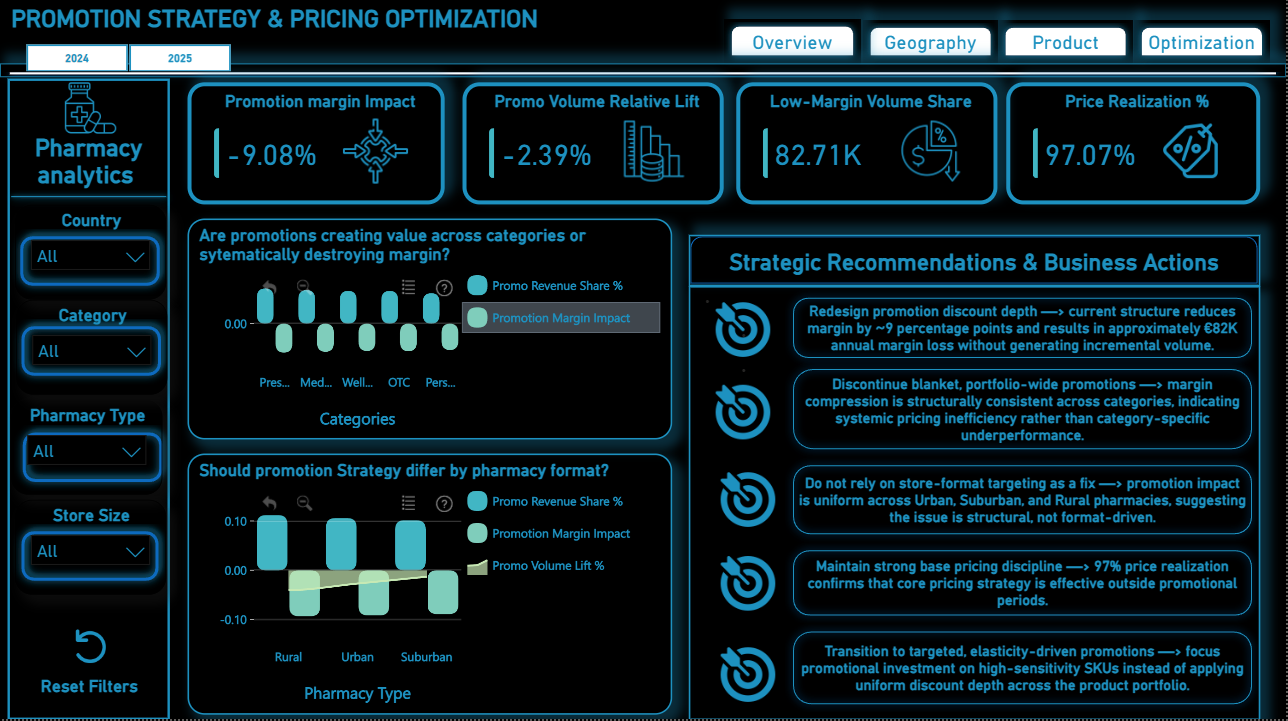